# 3. Expolartory Data Analysis

In [1]:
%load_ext autoreload
%autoreload 2

naming convetion

NOD : No Outlier Detection

OD : Outlier Detection

ra : rating best code A

rab : rating good code A +B

In [2]:
import os, sys, pickle
from pathlib import Path

#dir_path = os.path.dirname(os.path.abspath(os.curdir))
#os.chdir(dir_path)

from agrid.grid import Grid

import pandas as pd

import re
import copy

import numpy as np
from numpy import asarray
from numpy import save
from numpy import load

from scipy import stats, interpolate, spatial, io
from scipy.ndimage import gaussian_filter, median_filter
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import Arc 
import cartopy.crs as ccrs

import pyproj as proj
import rasterio


from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns

from joblib import Parallel, delayed
import multiprocessing
import numba as nb
from numba import jit

import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

sns.set_theme(style="white")

# evaluate model performance with outliers removed using isolation forest
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
# load the dataset


from sklearn.metrics import make_scorer , r2_score, explained_variance_score
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from skopt.space import Real, Categorical, Integer

from scipy import stats
from collections import OrderedDict

from sklearn.preprocessing import PowerTransformer


import pygmt


from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.compose import make_column_selector as selector


In [3]:
# constanst

#parent directory

dir_p = Path().resolve() 

#constants
km = 1000
milli = 0.001
micro = 0.000001



# We can exclude Arctic ocean and Antarctica, as there are no HF measurements to use
world_lon_min, world_lon_max, world_lat_min, world_lat_max  = -180, 180, -60, 80

# map extents of Africa and Australia
afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max =  -20, 52, -37 , 38  


# create grid for each region
# crs Coordinate reference system

#EPSG is projection
# 0.2 degrees equal roughly 20 km

World = Grid(res=[0.2, 0.2], up=world_lat_max, down=world_lat_min)


# africa grid low resolution 50 x 50 km

Africa =    Grid(res=[0.5, 0.5],  left = afr_lon_min, right= afr_lon_max, up=afr_lat_max , down=afr_lat_min)


#dictionary of all grids

grids = {}

grids['Afr'] = Africa
grids['World'] = World


In [4]:
# to ease looping with dictionaries

regions_a = [ 'Afr' ]


regions_Total = ['World' ,'Afr']


# raster exenets to adjust map
raster_extent_Afr = [grids['Afr'].extent[0], grids['Afr'].extent[1], grids['Afr'].extent[3], grids['Afr'].extent[2]]
raster_extent_World = [grids['World'].extent[0], grids['World'].extent[1], grids['World'].extent[3], grids['World'].extent[2]]

# to correct plot maps
raster_extents = {}

raster_extents['Afr'] = raster_extent_Afr
raster_extents['World'] = raster_extent_World


# list of latitudes and longitudes
lon_dict = {}
lat_dict = {}

lon_dict['Afr'] = [afr_lon_min, afr_lon_max]
lon_dict['World'] = [world_lon_min, world_lon_max]

lat_dict['Afr'] = [afr_lat_min, afr_lat_max]
lat_dict['World'] = [world_lat_min, world_lat_max]



print('terminated')

terminated


In [5]:
obs = pd.DataFrame()



obs['OBS_REF'] = [ 'SI',"LAB", "MOHO", 'CTD' , 
                "SV","PV",  'GEOID','FA',
                  'RHO_C','BG', 'EMAG2_CLASS','DEM',
                  'RHO_L','VOLC_DIST_W', 'REG', 'GLIM']




  
     
# Labels for plots etc
obs['LABELS'] = ['Shape index', 'LAB depth', 'Moho depth', 'CTD',  
                'S$_V$ 150km', 'P$_V$ 150km','Geoid', 'Free air', 
                 'Crust ρ','Bouguer', 'Mag.', 'DEM', 
                 'Lith. ρ', 'Volcano d.', 'GliM', 'REG', ]  
    
    
# 'vp/vs'
# Units to display in plots etc
obs['UNITS'] = ['km',  'si', 'km', 'km',
             '$\delta$ v_s %','$\delta$ v_p %', 'm', 'mGal', 
                'kg/m$^3$','mGal',  'f(nT)', 'm', 
                'kg/m$^3$', 'km',  'class', 'class']
        
# Range of colormap for plots. Similar data are placed in same ranges for consistancy
obs['V_RANGE'] = [(-1,1),(0,300),(15,60), (0,50), 
              (-0.075,0.075), (-0.02,0.02), (-45,45), (-100,100) , 
                  (2650, 2950),(-250,100),  (-0.4, 0.4), (-200, 2200),
                  (3260, 3360),(0,1), (1,6),(1,15),]
    
obs["CMAPS"] = ["batlow",  "broc", "bamako", "batlow", 
             "roma","roma", "bamako", "broc",
                "batlow",  "broc", "batlow", "bukavu",
                "batlow", "bamako",  "batlowS","topo", ]

#new_index = [4,3,15,6,7,0,14,10,16,17,9, 2,1,5,13,12, 8,11,]

#new_index = [4,3,15,6,7,0, 14, 10,16, 8, 9,2, 13, 12, 8, 11, ]

#obs = obs.reindex(new_index)

obs.index = np.arange(0,len(obs))

pd.options.display.width = 370
pd.options.display.max_colwidth = 12
print(obs)

n_obs = len(obs)

obs_dict = obs.to_dict(orient='records')



        OBS_REF       LABELS        UNITS      V_RANGE    CMAPS
0            SI  Shape index           km      (-1, 1)   batlow
1           LAB    LAB depth           si     (0, 300)     broc
2          MOHO   Moho depth           km     (15, 60)   bamako
3           CTD          CTD           km      (0, 50)   batlow
4            SV  S$_V$ 150km  $\delta$...  (-0.075,...     roma
5            PV  P$_V$ 150km  $\delta$...  (-0.02, ...     roma
6         GEOID        Geoid            m    (-45, 45)   bamako
7            FA     Free air         mGal  (-100, 100)     broc
8         RHO_C      Crust ρ     kg/m$^3$  (2650, 2...   batlow
9            BG      Bouguer         mGal  (-250, 100)     broc
10  EMAG2_CLASS         Mag.        f(nT)  (-0.4, 0.4)   batlow
11          DEM          DEM            m  (-200, 2...   bukavu
12        RHO_L      Lith. ρ     kg/m$^3$  (3260, 3...   batlow
13  VOLC_DIST_W   Volcano d.           km       (0, 1)   bamako
14          REG         GliM        clas

In [6]:
# helper function for plotting

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

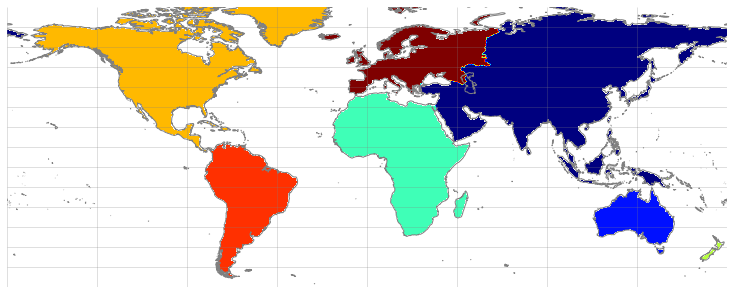

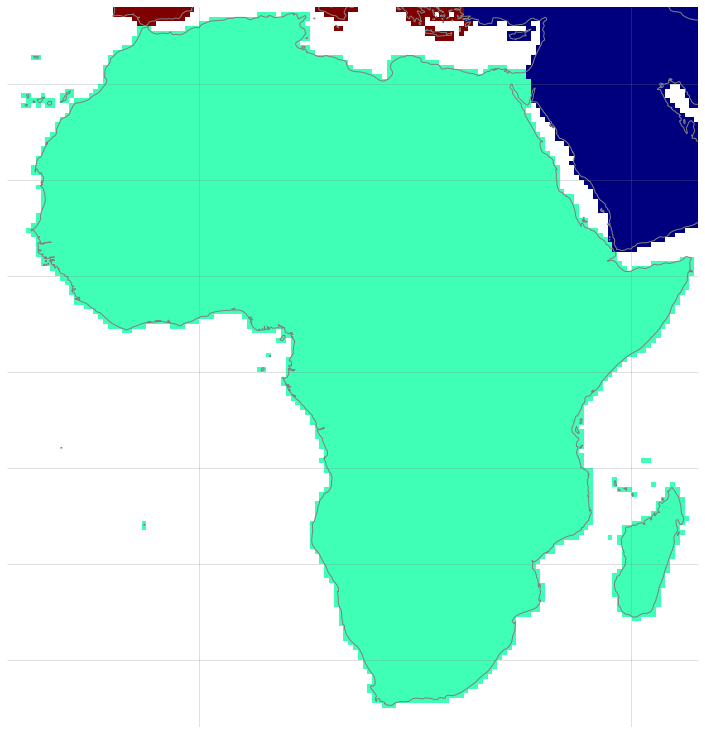

In [7]:
#https://github.com/nvkelso/natural-earth-vector
# natural earth 10 m land shape
ne_10m_land = dir_p / 'data'/ 'Shapefiles'/'NE'/ 'ne_10m_land.shp'
continents = dir_p /'data'/ 'Shapefiles'/'continents'/ 'continent.shp'

# LAND is water vs land
#Continet describes each continent

#assign_shape Rasterize vector polygons to grid 

for region in regions_Total:
    # Use continental plates instead
    grids[region].ds['LAND'] = (('Y', 'X'), grids[region].assign_shape(ne_10m_land, 
                                               'scalerank', map_to_int = False, burn_val = 1))


    grids[region].ds['CONTINENT'] = (('Y', 'X'), grids[region].assign_shape(continents, 
                                               'CONTINENT', map_to_int = True))
    
    
    
    grids[region].map_grid('CONTINENT', raster_extent= raster_extents[region], 
                         cmap='jet', figsize=(10,10))

    


import gridded data to the grid not necessary step just grid

# 3 - Convert to correct data types

In [8]:
### input####

training_w_ra_i =    dir_p /'data'/'dataset'/'Preprocessed'/'Training_W_merged_ra_int.csv' 

training_w_rab_i =   dir_p /'data'/'dataset'/'Preprocessed'/'Training_W_merged_rab_int.csv'

training_Afr_ra_i =   dir_p /'data'/'dataset'/'Preprocessed'/'Training_Afr_ra_int.csv'

training_Afr_rab_i =   dir_p /'data'/'dataset'/'Preprocessed'/'Training_Afr_rab_int.csv'


#####

hf_W_ra = pd.read_csv(training_w_ra_i)

hf_Afr_ra = pd.read_csv(training_Afr_ra_i)


hf_W_rab = pd.read_csv(training_w_rab_i)

hf_Afr_rab = pd.read_csv(training_Afr_rab_i)


###

hf_W_ra['GLIM']  = hf_W_ra['GLIM'].astype('int').astype('category')
hf_W_rab['GLIM']  = hf_W_rab['GLIM'].astype('int').astype('category')

hf_Afr_ra['GLIM']  = hf_Afr_ra['GLIM'].astype('int').astype('category')
hf_Afr_rab['GLIM']  = hf_Afr_rab['GLIM'].astype('int').astype('category')


hf_W_ra['REG']  = hf_W_ra['REG'].astype('int').astype('category')
hf_W_rab['REG']  = hf_W_rab['REG'].astype('int').astype('category')

hf_Afr_ra['REG']  = hf_Afr_ra['REG'].astype('int').astype('category')
hf_Afr_rab['REG']  = hf_Afr_rab['REG'].astype('int').astype('category')


In [9]:
hf_Afr_rab.describe(include='all')

lon          lat  heat-flow (mW/m2)   grid_index  dist_from_grid    VOLC_DIST  VOLC_DIST_W    LAND    CONTINENT           SV  ...        GEOID           FA           BG          DEM        EMAG2  EMAG2_CLASS    GLIM     REG     SV_SPEED     PV_SPEED
count   1814.000000  1814.000000  1814.000000        1814.000000  1814.000000     1814.000000  1814.000000  1555.0  1558.000000  1814.000000  ...  1814.000000  1814.000000  1814.000000  1814.000000  1.814000...  1814.000000  1814.0  1814.0  1814.000000  1814.000000
unique          NaN          NaN          NaN                NaN          NaN             NaN          NaN     NaN          NaN          NaN  ...          NaN          NaN          NaN          NaN          NaN          NaN    11.0     6.0          NaN          NaN
top             NaN          NaN          NaN                NaN          NaN             NaN          NaN     NaN          NaN          NaN  ...          NaN          NaN          NaN          NaN          NaN          NaN    15.0     1.0          NaN          NaN
freq            NaN          NaN          NaN                NaN          NaN             NaN          NaN     NaN          NaN          NaN  ...          NaN          NaN          NaN          NaN          NaN          NaN   591.0   617.0          NaN          NaN
mean      18.846542    14.866604    72.904465        14910.49...  20131.78...      500.096961     0.066702     1.0     3.124519     0.011259  ...    17.633253     8.137720   -19.446300   236.136163 -3.939322...    -0.010281     NaN     NaN     4.441409     8.131084
std       16.337371    19.549592    52.319720        5591.001411  7816.519445      506.765016     0.184074     0.0     1.841128     0.034196  ...    16.543910    24.987303    63.807406   667.581997  3.641008...     0.164982     NaN     NaN     0.150186     0.052486
min      -17.450000   -32.983000     1.000000        1234.000000  1164.422445        4.069446     0.000000     1.0     2.000000    -0.075006  ...   -37.404268   -56.312141  -187.715387 -2702.000000 -3.402823...    -1.000000     NaN     NaN     4.062493     7.973154
25%        8.097750    -4.940500    48.000000        9278.000000  14525.72...      136.925150     0.000000     1.0     2.000000    -0.021168  ...     6.425894   -14.258814   -60.954426   -55.000000 -3.571391...    -0.085521     NaN     NaN     4.298930     8.094028
50%       12.850000    26.827500    62.150000        18396.00...  20885.71...      312.253128     0.000000     1.0     2.000000     0.014767  ...    18.547354     9.436349    -6.140191   103.000000  4.236552...     0.010535     NaN     NaN     4.456814     8.125297
75%       34.646750    31.494250    79.000000        19692.00...  26530.45...      774.280125     0.000000     1.0     6.000000     0.041968  ...    28.780172    25.707870    16.352572   543.750000  3.618869...     0.086610     NaN     NaN     4.576267     8.170434
max       51.617000    37.992000   787.500000        21526.00...  37179.66...     2650.725261     0.959306     1.0     7.000000     0.087968  ...    54.874744   147.487410   150.504277  2482.000000  2.105071...     0.422825     NaN     NaN     4.778262     8.362201

[11 rows x 27 columns]

In [10]:

target = 'heat-flow (mW/m2)'
coord = ['lon', 'lat']
grid_index = ['grid_index']


#######

features_ex = []
features_ghf = []



features = obs['OBS_REF'].tolist()



in_features = set(features)

features_ex = copy.deepcopy(features)
features_ex.extend(coord)
features_ex.extend(grid_index)

features_ex.append(target)

features_ghf = copy.deepcopy(features)
features_ghf.append(target)




In [11]:
print(hf_W_ra.dtypes)

hf_W_rab.describe(include='all')

lon                   float64
lat                   float64
heat-flow (mW/m2)     float64
grid_index              int64
dist_from_grid        float64
VOLC_DIST             float64
VOLC_DIST_W           float64
LAND                  float64
CONTINENT             float64
SV                    float64
PV                    float64
CTD                   float64
MOHO                  float64
SI                    float64
LAB                   float64
RHO_C                 float64
RHO_L                 float64
GEOID                 float64
FA                    float64
BG                    float64
DEM                   float64
EMAG2                 float64
EMAG2_CLASS           float64
GLIM                 category
REG                  category
SV_SPEED              float64
PV_SPEED              float64
dtype: object


lon          lat  heat-flow (mW/m2)   grid_index  dist_from_grid    VOLC_DIST  VOLC_DIST_W     LAND    CONTINENT           SV  ...        GEOID           FA           BG          DEM        EMAG2  EMAG2_CLASS     GLIM      REG     SV_SPEED     PV_SPEED
count   12707.00...  12707.00...  12707.00...        1.270700...  12707.00...     12707.00...  12707.00...  11519.0  11568.00...  12707.00...  ...  12707.00...  12707.00...  12707.00...  12707.00...  1.270700...  12707.00...  12707.0  12707.0  1814.000000  1814.000000
unique          NaN          NaN          NaN                NaN          NaN             NaN          NaN      NaN          NaN          NaN  ...          NaN          NaN          NaN          NaN          NaN          NaN     15.0      6.0          NaN          NaN
top             NaN          NaN          NaN                NaN          NaN             NaN          NaN      NaN          NaN          NaN  ...          NaN          NaN          NaN          NaN          NaN          NaN      1.0      3.0          NaN          NaN
freq            NaN          NaN          NaN                NaN          NaN             NaN          NaN      NaN          NaN          NaN  ...          NaN          NaN          NaN          NaN          NaN          NaN   3008.0   4582.0          NaN          NaN
mean      -6.227387    35.804512    66.098275        8.601673...  7458.753005      617.558503     0.112870      1.0     6.408887     0.016201  ...    -3.204703    -0.121640   -64.801515   545.487212 -3.668740...    -0.111758      NaN      NaN     4.441409     8.131084
std       82.761715    22.297519    61.996066        1.999767...  2975.685865      651.804832     0.242148      0.0     1.764465     0.034939  ...    29.268490    29.252009    87.038793   799.225513  1.055414...     0.327733      NaN      NaN     0.150186     0.052486
min     -179.927000   -54.000000    -3.000000        5.452400...   111.706916        0.964597     0.000000      1.0     2.000000    -0.080519  ...   -96.078190  -141.928486  -552.302525 -5148.000000 -3.402823...    -1.000000      NaN      NaN     4.062493     7.973154
25%      -98.640000    32.491000    45.000000        8.297175...  5266.482812      113.864011     0.000000      1.0     6.000000    -0.013723  ...   -23.994622   -14.618195  -120.152808    50.000000 -4.652511...    -0.110031      NaN      NaN     4.298930     8.094028
50%       11.597000    40.705000    59.000000        9.040950...  7616.416706      321.197759     0.000000      1.0     7.000000     0.018331  ...   -12.440405     0.058912   -45.297155   316.000000 -7.858570...    -0.019456      NaN      NaN     4.456814     8.125297
75%       50.250000    48.667000    77.000000        9.756270...  9837.969505      923.474035     0.000000      1.0     8.000000     0.043901  ...    20.332581    15.782159    -9.455454   938.500000  1.954649...     0.047710      NaN      NaN     4.576267     8.170434
max      179.851000    79.000000  5146.000000        1.247886...  15584.63...     2941.208973     0.990354      1.0     8.000000     0.102761  ...    72.820300   170.295749   334.894929  5109.000000  4.181506...     0.715582      NaN      NaN     4.778262     8.362201

[11 rows x 27 columns]

In [12]:


hf_W_ra[features].isna().sum()



hf_Afr_rab[features].isna().sum()

SI             0
LAB            0
MOHO           0
CTD            0
SV             0
PV             0
GEOID          0
FA             0
RHO_C          0
BG             0
EMAG2_CLASS    0
DEM            0
RHO_L          0
VOLC_DIST_W    0
REG            0
GLIM           0
dtype: int64

In [13]:
hf_W_ra['REG'].cat.codes

0       2
1       5
2       1
3       3
4       2
       ..
5787    2
5788    3
5789    2
5790    5
5791    5
Length: 5792, dtype: int8

In [14]:
hf_W_rab.isna().sum()

lon                      0
lat                      0
heat-flow (mW/m2)        0
grid_index               0
dist_from_grid           0
VOLC_DIST                0
VOLC_DIST_W              0
LAND                  1188
CONTINENT             1139
SV                       0
PV                       0
CTD                      0
MOHO                     0
SI                       0
LAB                      0
RHO_C                    0
RHO_L                    0
GEOID                    0
FA                       0
BG                       0
DEM                      0
EMAG2                    0
EMAG2_CLASS              0
GLIM                     0
REG                      0
SV_SPEED             10893
PV_SPEED             10893
dtype: int64

# 4- Replace missing data

In [15]:

hf_W_copy_ra = hf_W_ra.loc[hf_W_ra[features_ghf].dropna().index, features_ex].reset_index(drop=True)

hf_W_copy_rab = hf_W_rab.loc[hf_W_rab[features_ghf].dropna().index, features_ex].reset_index(drop=True)


hf_Afr_copy_ra = hf_Afr_ra.loc[hf_Afr_ra[features_ghf].dropna().index, features_ex].reset_index(drop=True)

hf_Afr_copy_rab = hf_Afr_rab.loc[hf_Afr_rab[features_ghf].dropna().index, features_ex].reset_index(drop=True)



hf_Afr_copy_rab[hf_Afr_copy_rab[target]>=200]['lon'].values

array([34.302, 34.313, 34.445, 34.47 , 34.488, 34.492, 34.503, 34.582,
       34.625, 34.668, 34.72 , 34.735, 34.755, 34.775, 34.788, 34.807,
       34.828, 34.84 , 34.845, 34.865, 34.882, 34.895, 34.897, 34.903,
       34.925, 34.938, 34.94 , 34.948, 34.98 , 34.995, 35.195, 35.212,
       35.215, 35.232, 35.248, 35.482, 35.517, 36.   , 39.803, 41.408,
       42.463, 42.475, 42.477, 42.477, 42.483, 42.485, 42.485, 43.013])

In [16]:
# count = no null

hf_W_copy_ra[features_ex].isnull().sum(0)
#hf_W_copy_rg[features_all].isnull().sum(0)

SI                   0
LAB                  0
MOHO                 0
CTD                  0
SV                   0
PV                   0
GEOID                0
FA                   0
RHO_C                0
BG                   0
EMAG2_CLASS          0
DEM                  0
RHO_L                0
VOLC_DIST_W          0
REG                  0
GLIM                 0
lon                  0
lat                  0
grid_index           0
heat-flow (mW/m2)    0
dtype: int64

# insight into observables

(12707, 20)


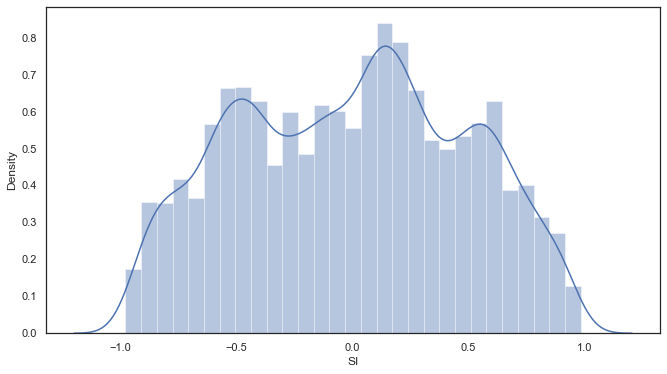

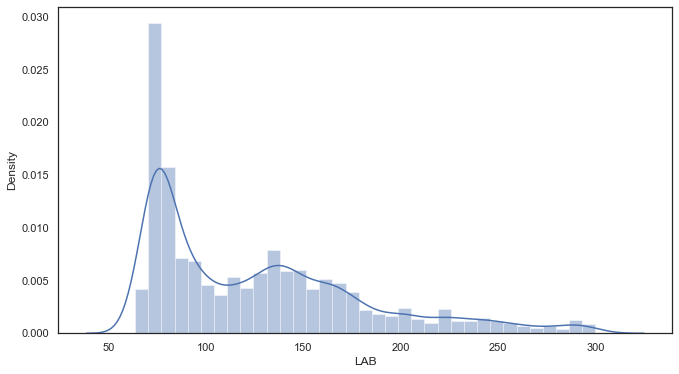

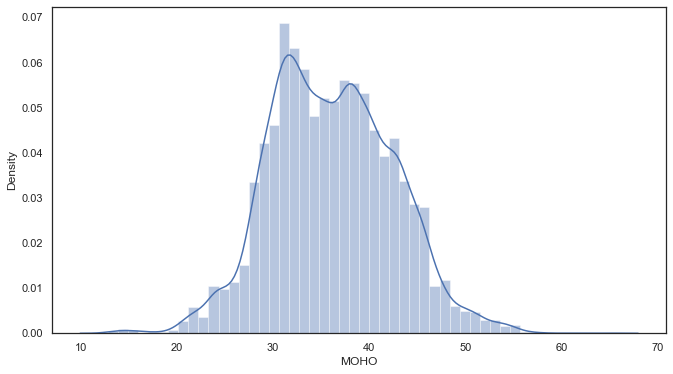

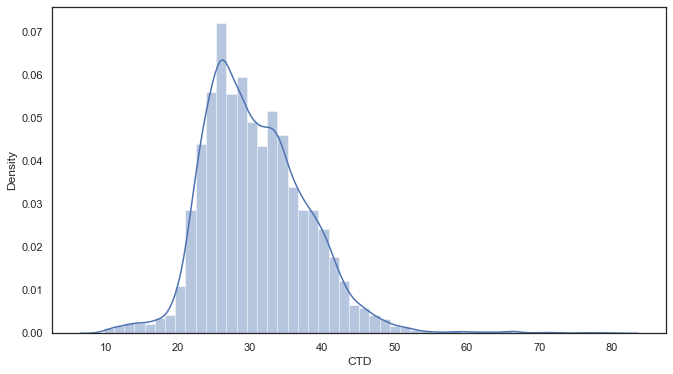

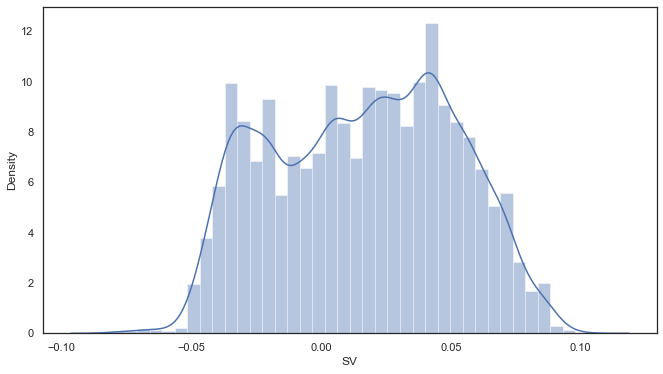

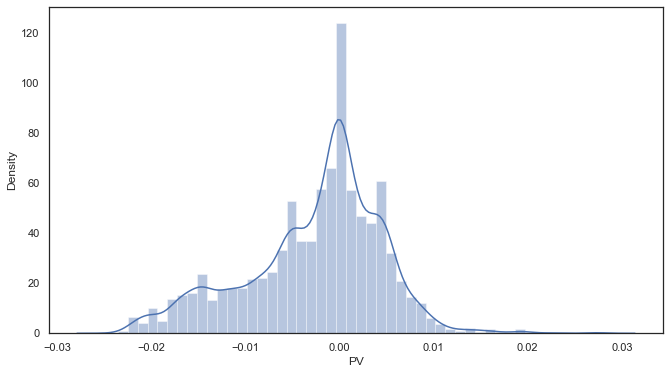

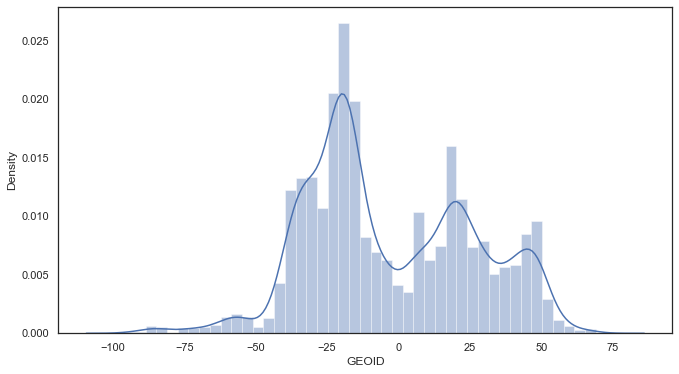

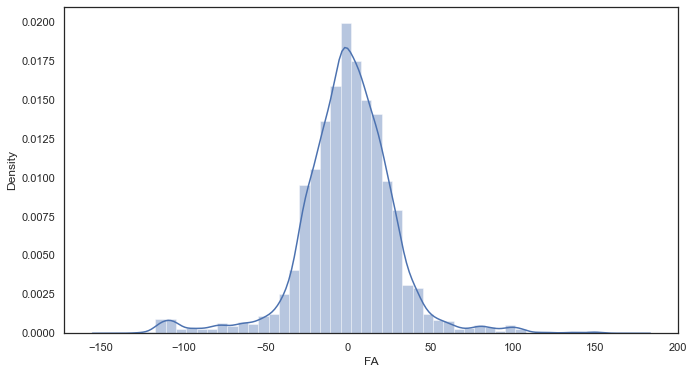

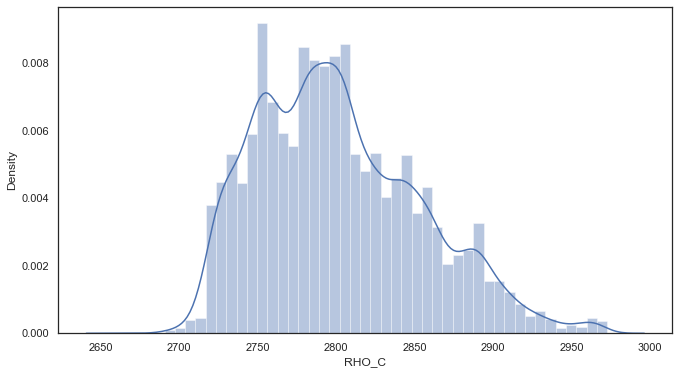

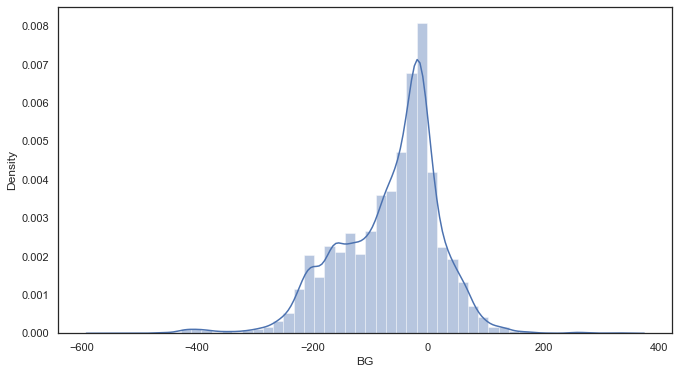

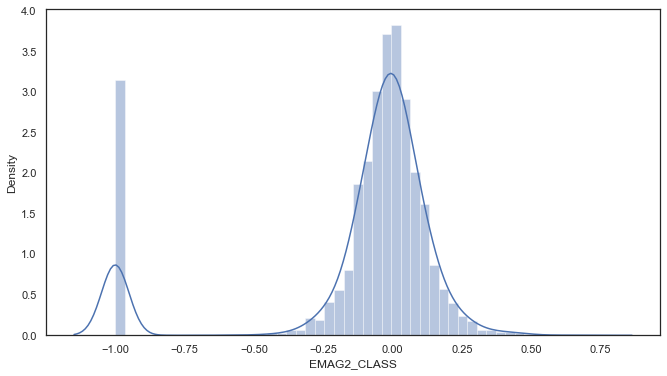

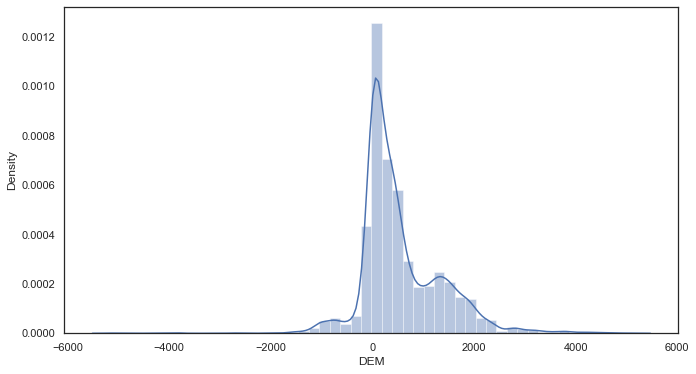

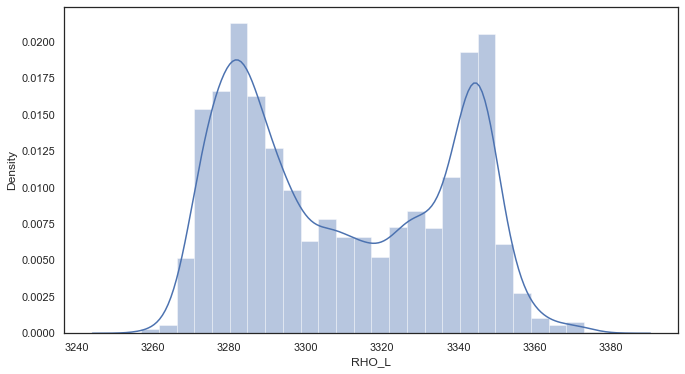

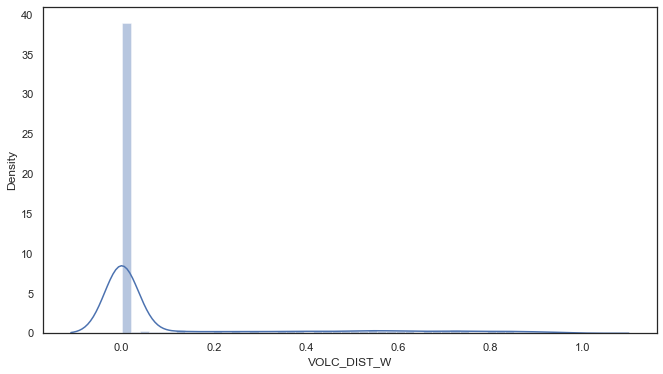

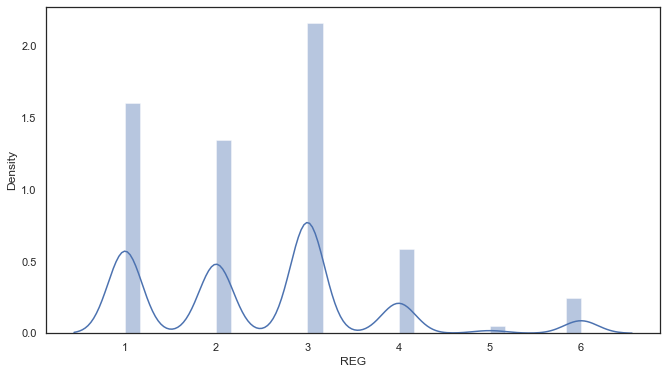

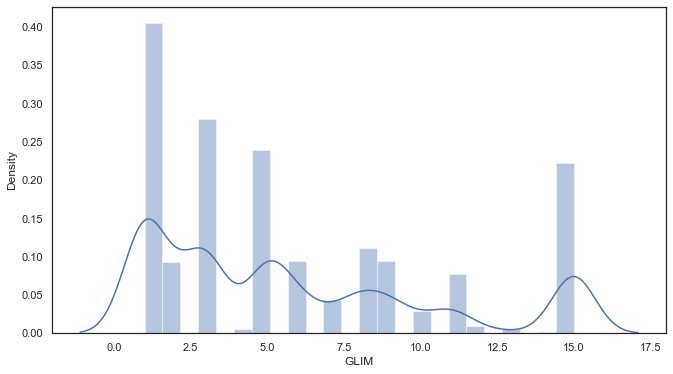

In [22]:
hf_W_copy_rab

print(hf_W_copy_rab.shape)

l = [hf_W_copy_rab[column] for column in features]

for i in l:
    plt.figure(figsize=(11,6))

    sns.distplot(i,  kde=True)



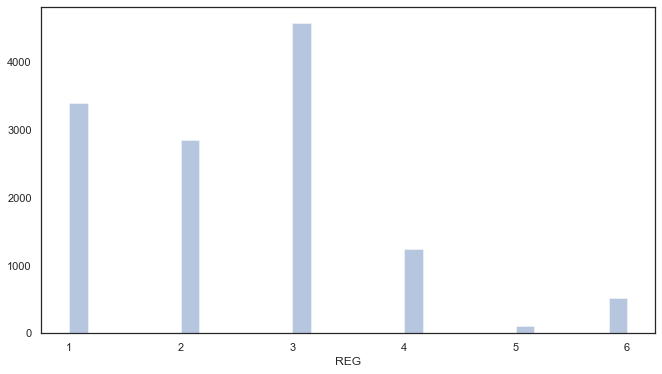

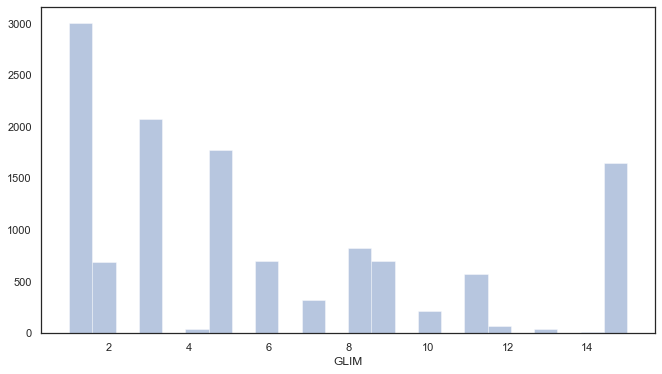

In [23]:
l = [hf_W_copy_rab[column] for column in features[-2:]]

for i in l:
    plt.figure(figsize=(11,6))

    sns.distplot(i,  kde=False)


# 5- outliers detection for traget

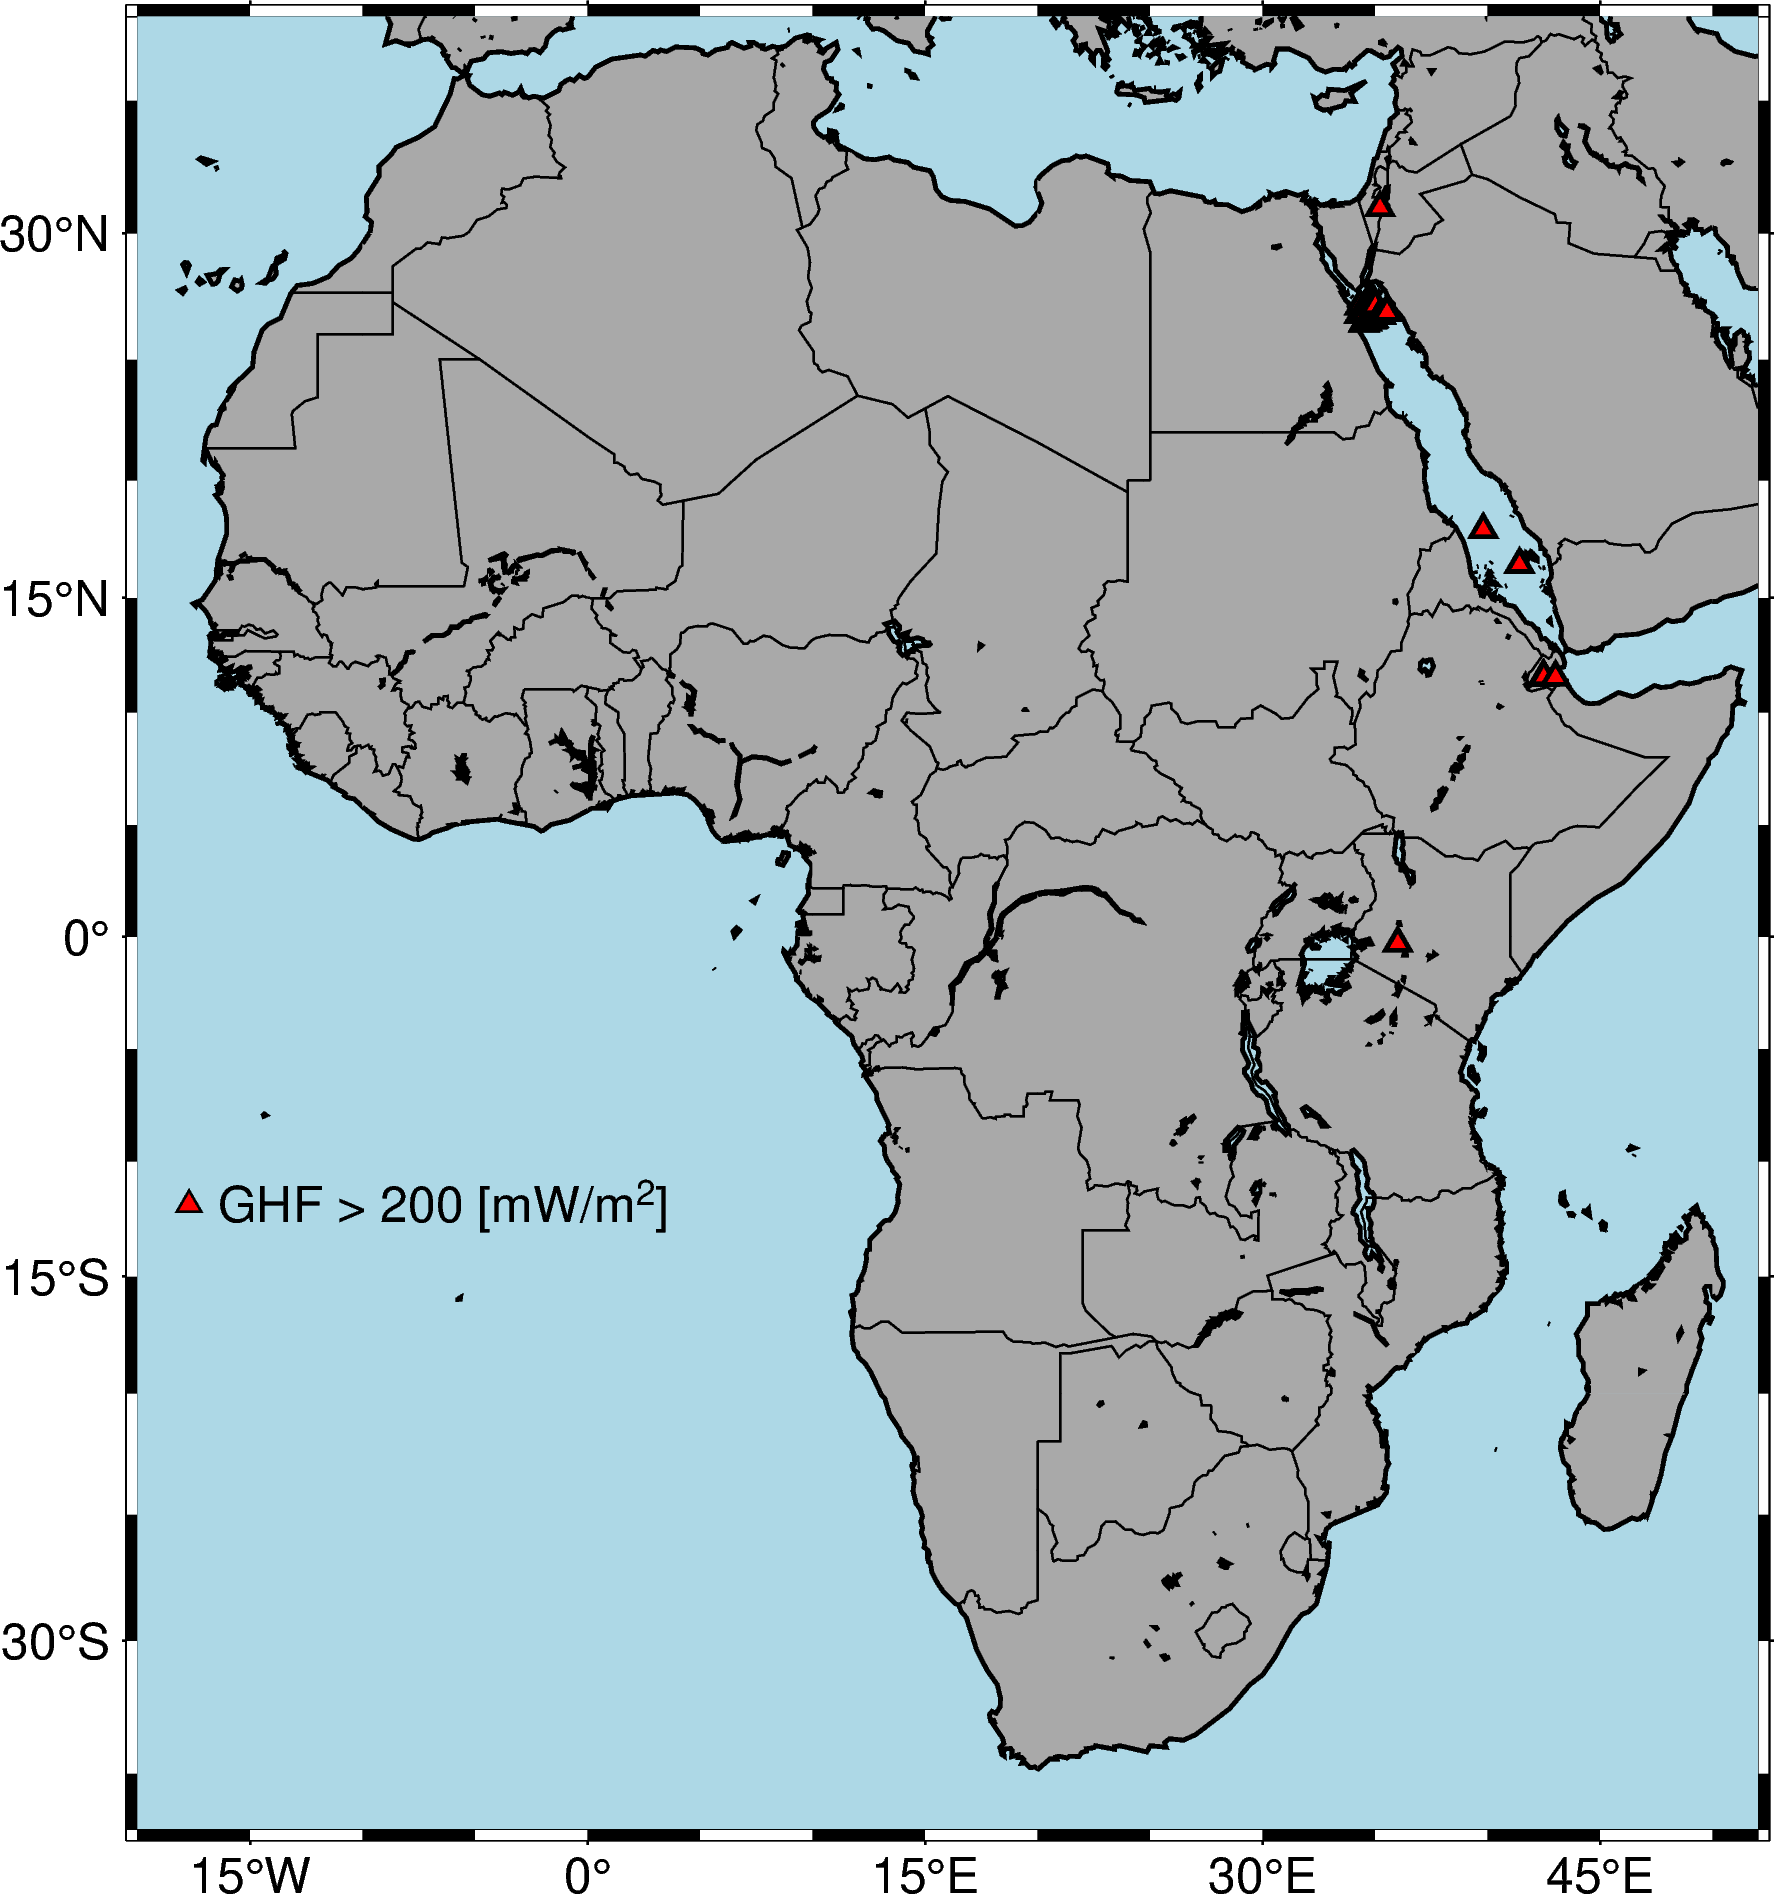

In [33]:
proj = "N12c"

proj = 'M5.4i'

fig = pygmt.Figure()
pygmt.config(FONT='12p')

with fig.subplot(
    nrows=1,
    ncols=2,
    figsize=("13.5c", "13.5c"),  # width of 15 cm, height of 6 cm
    #subsize = ("15c", "15c"),
    #autolabel=True,
    margins=["0.2c", "1.5c"],  # horizontal 0.3 cm and vertical 0.2 cm margins
    ):


        
             #### RK with point
    with fig.set_panel(panel=[0, 0]):

        #fig.basemap(region=region, projection=proj, frame=True, panel=[0, 0])
        fig.basemap(region=[afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max],projection=proj,  panel=[0, 1])

        fig.plot(x=0, y=0,  projection=proj,
             color='red', label='"GHF > 200\t[mW/m@+2@+]"',
                      pen="0.5p", style="t0.24c")
        fig.coast(
            projection=proj,
            #shorelines=0.5,
            water="lightblue", shorelines="1p,black",
            borders=["1/0.5p,black"], land='darkgrey'
            #water='white',
            )

        fig.plot(x=hf_Afr_copy_rab[hf_Afr_copy_rab[target]>=200]['lon'].values, 
                 y=hf_Afr_copy_rab[hf_Afr_copy_rab[target]>=200]['lat'].values,   
                 color='red',  projection=proj, 
                          pen="1p,black", style="t0.24c")

        #fig.legend( position='JTR+jTR+o0.1c', projection=proj, 
            #box='+gwhite+p0.5p',)
    fig.legend(position="g-18/-50", box=False)

    fig.show(width=800, dpi=300)
    
fig.savefig(dir_p/'fig'/"fig_s2.pdf", dpi=300 )
fig.savefig(dir_p/'fig'/"fig_s2.jpg", dpi=300 )

In [25]:
# drop values greater than 200 labeled _n


####rb

hf_W_copy_ra_n  = hf_W_copy_ra.drop(hf_W_copy_ra[hf_W_copy_ra[target] >= 200].index)
hf_W_copy_ra_n  = hf_W_copy_ra_n.drop(hf_W_copy_ra_n[hf_W_copy_ra_n[target] <= 0].index)

hf_Afr_copy_ra_n = hf_Afr_copy_ra.drop(hf_Afr_copy_ra[hf_Afr_copy_ra[target] >= 200].index)
hf_Afr_copy_ra_n = hf_Afr_copy_ra_n.drop(hf_Afr_copy_ra_n[hf_Afr_copy_ra_n[target] <= 0].index)


######rg

hf_W_copy_rab_n  = hf_W_copy_rab.drop(hf_W_copy_rab[hf_W_copy_rab[target] >= 200].index)
hf_W_copy_rab_n  = hf_W_copy_rab_n.drop(hf_W_copy_rab_n[hf_W_copy_rab_n[target] <= 0].index)

hf_Afr_copy_rab_n = hf_Afr_copy_rab.drop(hf_Afr_copy_rab[hf_Afr_copy_rab[target] >= 200].index)
hf_Afr_copy_rab_n = hf_Afr_copy_rab_n.drop(hf_Afr_copy_rab_n[hf_Afr_copy_rab_n[target] <= 0].index)


print('hf_W_copy_ra')
print(len(hf_W_copy_ra))
print(f'max {hf_W_copy_ra[target].max()}')
print(f'min {hf_W_copy_ra[target].min()}')

print('hf_W_copy_ra_n')
print(len(hf_W_copy_ra_n))
print(f'max {hf_W_copy_ra_n[target].max()}')
print(f'min {hf_W_copy_ra_n[target].min()}')

print('hf_W_copy_rab')
print(len(hf_W_copy_rab))
print(f'max {hf_W_copy_rab[target].max()}')
print(f'min {hf_W_copy_rab[target].min()}')

print('hf_W_copy_rab_n')
print(len(hf_W_copy_rab_n))
print(f'max {hf_W_copy_rab_n[target].max()}')
print(f'min {hf_W_copy_rab_n[target].min()}')

#####
print('hf_Afr_copy_ra')
print(len(hf_Afr_copy_ra))
print(f'max {hf_Afr_copy_ra[target].max()}')
print(f'min {hf_Afr_copy_ra[target].min()}')

print('hf_Afr_copy_ra_n')
print(len(hf_Afr_copy_ra_n))
print(f'max {hf_Afr_copy_ra_n[target].max()}')
print(f'min {hf_Afr_copy_ra_n[target].min()}')

print('hf_Afr_copy_rab')
print(len(hf_Afr_copy_rab))
print(f'max {hf_Afr_copy_rab[target].max()}')
print(f'min {hf_Afr_copy_rab[target].min()}')

print('hf_Afr_copy_rab_n')
print(len(hf_Afr_copy_rab_n))
print(f'max {hf_Afr_copy_rab_n[target].max()}')
print(f'min {hf_Afr_copy_rab_n[target].min()}')





# save datasets for training


### ra
training_w_nod_ra_n  =    dir_p /'data'/'dataset'/'Preprocessed'/'Training_W_NOD_ra.csv'

hf_Afr_nod_ra_n  =   dir_p /'data'/'dataset'/'Preprocessed'/'Training_Afr_NOD_ra.csv'



hf_W_copy_ra_n.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
hf_W_copy_ra_n.reset_index( inplace=True,drop=True)
hf_W_copy_ra_n.to_csv(training_w_nod_ra_n , index=False, header=True, sep='\t')



####

hf_Afr_copy_ra_n.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
hf_Afr_copy_ra_n.reset_index( inplace=True,drop=True)
hf_Afr_copy_ra_n.to_csv(hf_Afr_nod_ra_n , index=False, header=True, sep='\t')


####

####

##### rab

# save datasets for training


training_w_nod_rab_n  =    dir_p /'data'/'dataset'/'Preprocessed'/'Training_W_NOD_rab.csv'

hf_Afr_nod_rab_n  =   dir_p /'data'/'dataset'/'Preprocessed'/'Training_Afr_NOD_rab.csv'



hf_W_copy_rab_n.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
hf_W_copy_rab_n.reset_index( inplace=True,drop=True)
hf_W_copy_rab_n.to_csv(training_w_nod_rab_n , index=False, header=True, sep='\t')



####

hf_Afr_copy_rab_n.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
hf_Afr_copy_rab_n.reset_index( inplace=True,drop=True)
hf_Afr_copy_rab_n.to_csv(hf_Afr_nod_rab_n , index=False, header=True , sep='\t')



####


hf_W_copy_ra
5792
max 787.5
min 0.8
hf_W_copy_ra_n
5729
max 197.0
min 0.8
hf_W_copy_rab
12707
max 5146.0
min -3.0
hf_W_copy_rab_n
12591
max 199.0
min 0.8
hf_Afr_copy_ra
925
max 787.5
min 6.0
hf_Afr_copy_ra_n
879
max 197.0
min 6.0
hf_Afr_copy_rab
1814
max 787.5
min 1.0
hf_Afr_copy_rab_n
1766
max 197.7
min 1.0


In [26]:
hf_Afr_copy_rab_n

SI         LAB       MOHO        CTD        SV        PV      GEOID         FA        RHO_C          BG  EMAG2_CLASS     DEM        RHO_L  VOLC_DIST_W REG GLIM     lon     lat  grid_index  heat-flow (mW/m2)
0     0.933484  112.976530  25.708034  22.507461  0.010021 -0.007703  28.777662  16.009990  2791.351466  102.194300     0.060112    28.0  3335.865830     0.877958   6    3 -17.450  14.750       14837         66.8      
1     0.933484  112.976530  25.708034  22.507461  0.010021 -0.007703  28.777662  16.009990  2791.351466  102.194300     0.060112    28.0  3335.865830     0.877958   6    3 -17.433  14.683       14837         81.0      
2     0.933484  112.976530  25.708034  22.507461  0.010021 -0.007703  28.777662  16.009990  2791.351466  102.194300     0.060112    28.0  3335.865830     0.877958   6    3 -17.433  14.717       14837         73.2      
3     0.933484  112.976530  25.708034  22.507461  0.010021 -0.007703  28.777662  16.009990  2791.351466  102.194300     0.060112    28.0  3335.865830     0.877958   6    3 -17.433  14.733       14837         78.5      
4     0.933484  112.976530  25.708034  22.507461  0.010021 -0.007703  28.777662  16.009990  2791.351466  102.194300     0.060112    28.0  3335.865830     0.877958   6    3 -17.417  14.700       14837         67.7      
...        ...         ...        ...        ...       ...       ...        ...        ...          ...         ...          ...     ...          ...          ...  ..  ...     ...     ...         ...          ...      
1761  0.766193   69.261390  29.088212  19.348889  0.003610 -0.010940 -28.031926  52.847828  2780.624135  -21.886982    -0.003435  1177.0  3285.211875     0.000000   2    6  49.750  10.667       13819         59.0      
1762 -0.320319   82.167650  26.317240  21.403241  0.033617 -0.010427 -37.404268  10.330066  2816.476783   38.892787     0.029141   287.0  3304.783153     0.000000   2    6  50.517   9.550       13388         59.0      
1763 -0.320319   82.167650  26.317240  21.403241  0.033617 -0.010427 -37.404268  10.330066  2816.476783   38.892787     0.029141   287.0  3304.783153     0.000000   2    6  50.667   9.417       13388         59.0      
1764 -0.155005   72.119747  24.509425  20.786140  0.021729 -0.010764 -33.291200   7.114842  2780.455822   14.922675     0.016540   242.0  3282.138780     0.000000   2    1  51.000  10.617       13821         54.0      
1765  0.555865   92.916624  45.719106  34.895088  0.008880 -0.001631   4.216432  87.330399  2748.178304 -107.664819     0.052052   969.0  3268.605545     0.000000   3    6  51.617  35.667       20878         88.0      

[1766 rows x 20 columns]

 less than 0 : 0,   0.0 %
 greater than 200 : 62, 0.0107 %
 total length before elimination : 5792
 total length after elimination values < 200 : 5729


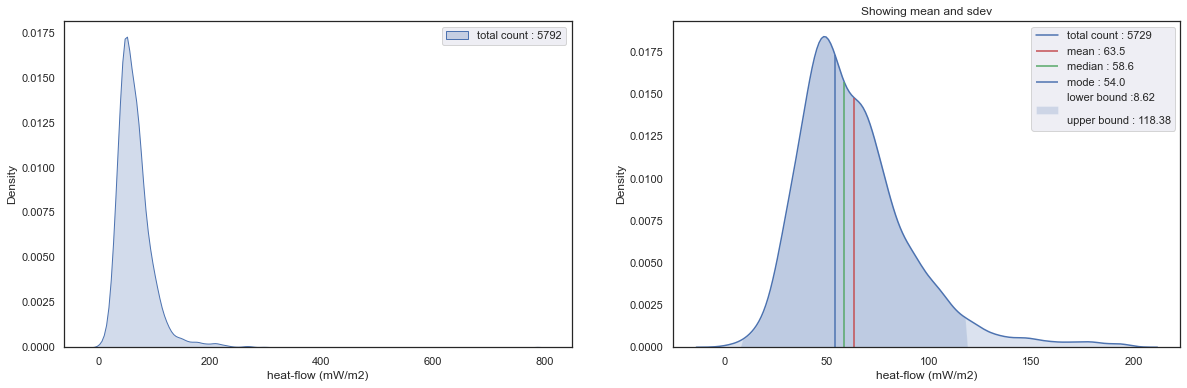

In [27]:
fig, axes = plt.subplots(1,2, figsize=(20, 6))


# data is positvely skewed

sns.set(font_scale = 1)

print(f' less than 0 : {len(hf_W_copy_ra[hf_W_copy_ra[target] <=0])},   {round(len(hf_W_copy_ra[hf_W_copy_ra[target] <= 0])/len(hf_W_copy_ra), 4)} %')
print(f' greater than 200 : {len(hf_W_copy_ra[hf_W_copy_ra[target] > 200])}, {round(len(hf_W_copy_ra[hf_W_copy_ra[target] > 200])/len(hf_W_copy_ra), 4)} %')
print(f' total length before elimination : {len(hf_W_copy_ra)}')
print(f' total length after elimination values < 200 : {len(hf_W_copy_ra_n)}')
#print(f' total length after transforming values < 200 : {len(hf_W_copy_ra_c)}')


######

sns.kdeplot(hf_W_copy_ra[target], shade=True,  ax=axes[0],  label=f'total count : {len(hf_W_copy_ra[target])}')

axes[0].legend()

#####
sns.kdeplot(hf_W_copy_ra_n[target], shade=False,  ax=axes[1], label=f'total count : {len(hf_W_copy_ra_n)}')
kdeline = axes[1].lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

mean = hf_W_copy_ra_n[target].mean()
median = hf_W_copy_ra_n[target].median()
mode = hf_W_copy_ra_n[target].mode()
sdev = hf_W_copy_ra_n[target].std()
left = mean - 2*sdev
right = mean + 2*sdev


axes[1].set_title('Showing mean and sdev') 
axes[1].vlines(mean, 0, np.interp(mean, xs, ys),   label= f'mean : {round(mean,2)}',  color='r')
axes[1].vlines(median, 0, np.interp(median, xs, ys),  label= f'median : {round(median,2)}',  color='g')
axes[1].vlines(mode, 0, np.interp(mode, xs, ys),  label= f'mode : {round(mode[0],2)}',  color='b')

axes[1].fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True,  alpha=0.2)

axes[1].fill_between(xs, 0, ys, alpha=0.2, facecolor ='b', label= f'''lower bound :{round(left,2)} \n 
upper bound : {round(right, 2)}''' )
axes[1].set_ylim(ymin=0)

axes[1].legend()



plt.show()



 less than 0 : 1,   0.0001 %
 greater than 200 : 112, 0.0088 %
 total length before elimination : 12707
 total length after elimination values < 200 : 12591


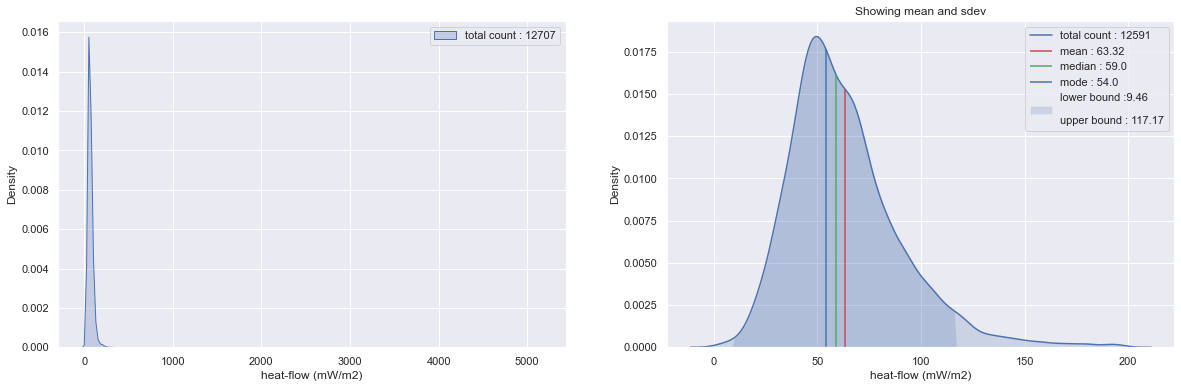

In [28]:
fig, axes = plt.subplots(1,2, figsize=(20, 6))


# data is positvely skewed
sns.set(font_scale = 1)


print(f' less than 0 : {len(hf_W_copy_rab[hf_W_copy_rab[target] <=0])},   {round(len(hf_W_copy_rab[hf_W_copy_rab[target] <= 0])/len(hf_W_copy_rab), 4)} %')
print(f' greater than 200 : {len(hf_W_copy_rab[hf_W_copy_rab[target] > 200])}, {round(len(hf_W_copy_rab[hf_W_copy_rab[target] > 200])/len(hf_W_copy_rab), 4)} %')
print(f' total length before elimination : {len(hf_W_copy_rab)}')
print(f' total length after elimination values < 200 : {len(hf_W_copy_rab_n)}')
#print(f' total length after transforming values < 200 : {len(hf_W_copy_rab_c)}')


######

sns.kdeplot(hf_W_copy_rab[target], shade=True,  ax=axes[0],  label=f'total count : {len(hf_W_copy_rab[target])}')

axes[0].legend()

#####
sns.kdeplot(hf_W_copy_rab_n[target], shade=False,  ax=axes[1], label=f'total count : {len(hf_W_copy_rab_n)}')
kdeline = axes[1].lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

mean = hf_W_copy_rab_n[target].mean()
median = hf_W_copy_rab_n[target].median()
mode = hf_W_copy_rab_n[target].mode()
sdev = hf_W_copy_rab_n[target].std()
left = mean - 2*sdev
right = mean + 2*sdev


axes[1].set_title('Showing mean and sdev') 
axes[1].vlines(mean, 0, np.interp(mean, xs, ys),   label= f'mean : {round(mean,2)}',  color='r')
axes[1].vlines(median, 0, np.interp(median, xs, ys),  label= f'median : {round(median,2)}',  color='g')
axes[1].vlines(mode, 0, np.interp(mode, xs, ys),  label= f'mode : {round(mode[0],2)}',  color='b')

axes[1].fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True,  alpha=0.2)

axes[1].fill_between(xs, 0, ys, alpha=0.2, facecolor ='b', label= f'''lower bound :{round(left,2)} \n 
upper bound : {round(right, 2)}''' )
axes[1].set_ylim(ymin=0)

axes[1].legend()



plt.show()



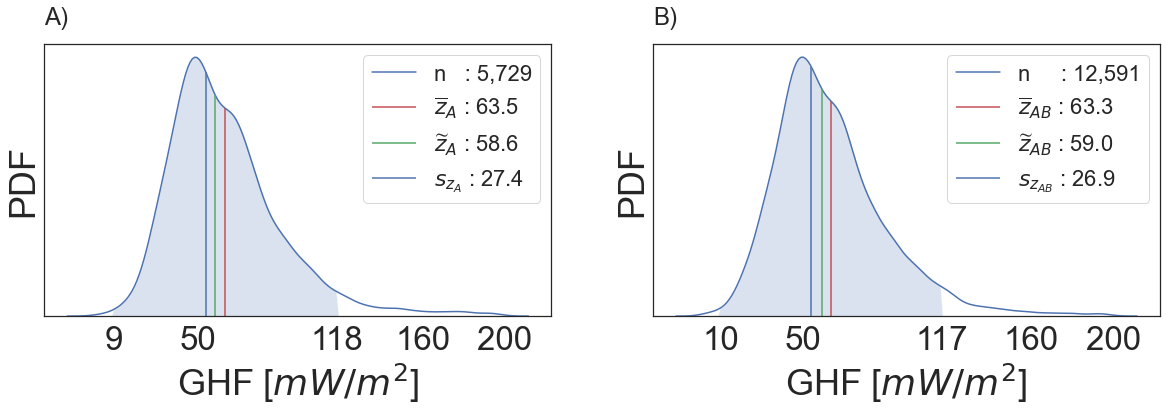

In [37]:
fig, axes = plt.subplots(1,2, figsize=(20, 5))
sub_figs = list('abcdefghijklmnopqrstuvwxyz')
sub_figs = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

# data is positvely skewed

sns.set(style='white', font_scale = 2)


######


#####
sns.kdeplot(hf_W_copy_ra_n[target], shade=False,  ax=axes[0], label=f'n   : {len(hf_W_copy_ra_n) :,}')

mean_a = "$\overline{z}_{A}$"
median_a = "$\widetilde{z}_{A}$"
std_a = "$s_{{z}_{A}}$"

kdeline = axes[0].lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

mean = hf_W_copy_ra_n[target].mean()
median = hf_W_copy_ra_n[target].median()
mode = hf_W_copy_ra_n[target].mode()
sdev = hf_W_copy_ra_n[target].std()
left = round(mean - 2*sdev,1)
right = round(mean + 2*sdev, 1)

axes[0].vlines(mean, 0, np.interp(mean, xs, ys),   label= f'{mean_a} : {round(mean,1)}',  color='r')
axes[0].vlines(median, 0, np.interp(median, xs, ys),  label= f'{median_a} : {round(median,2)}',  color='g')
#axes[0].vlines(mode, 0, np.interp(mode, xs, ys),  label= f'Mode : {round(mode[0],1)}',  color='b')
axes[0].vlines(mode, 0, np.interp(mode, xs, ys),  label= f'{std_a} : {round(sdev,1)}',  color='b')

axes[0].fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True,  alpha=0.2)


axes[0].set_ylim(ymin=0)

axes[0].legend()
#axes[0].axes.get_yaxis().set_visible(False)

axes[0].set_title(f'{sub_figs[0]})', loc ='left', pad=20)
#axes[0].set_xlabel('GHF  ($mW/m^{2}$)')

axes[0].set_xticks(np.round([right, 50,   left,  160, 200],0))
axes[0].set(xlabel='GHF [$mW/m^{2}$]', ylabel='PDF' )
axes[0].set_yticks([]) 
##

sns.kdeplot(hf_W_copy_rab_n[target], shade=False,  ax=axes[1], label=f'n     : {len(hf_W_copy_rab_n) :,}')

kdeline = axes[1].lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

mean_ab = "$\overline{z}_{AB}$"
median_ab = "$\widetilde{z}_{AB}$"
std_ab = "$s_{{z}_{AB}}$"

mean = hf_W_copy_rab_n[target].mean()
median = hf_W_copy_rab_n[target].median()
mode = hf_W_copy_rab_n[target].mode()
sdev = hf_W_copy_rab_n[target].std()
left = round(mean - 2*sdev, 1)
right = round(mean + 2*sdev, 1)

axes[1].vlines(mean, 0, np.interp(mean, xs, ys),   label= f'{mean_ab} : {round(mean,1)}',  color='r')
axes[1].vlines(median, 0, np.interp(median, xs, ys),  label= f'{median_ab} : {round(median,1)}',  color='g')
#axes[1].vlines(mode, 0, np.interp(mode, xs, ys),  label= f'Mode : {round(mode[0],2)}',  color='b')
axes[1].vlines(mode, 0, np.interp(mode, xs, ys),  label= f'{std_ab} : {round(sdev,1)}',  color='b')

axes[1].fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True,  alpha=0.2)

axes[1].set_ylim(ymin=0)

axes[1].legend(loc='upper right')

#axes[1].axes.get_yaxis().set_visible(False)
axes[1].set_yticks([]) 
axes[1].set_title(f'{sub_figs[1]})', loc ='left', pad=20)


axes[1].set(xlabel='GHF [$mW/m^{2}$]', ylabel='PDF' )
axes[1].set_xticks(np.round([ right, 50,   left,  160, 200],0))

plt.show()

fig.savefig(dir_p/'fig'/"fig_s1a.jpeg", bbox_inches='tight', dpi=300 )


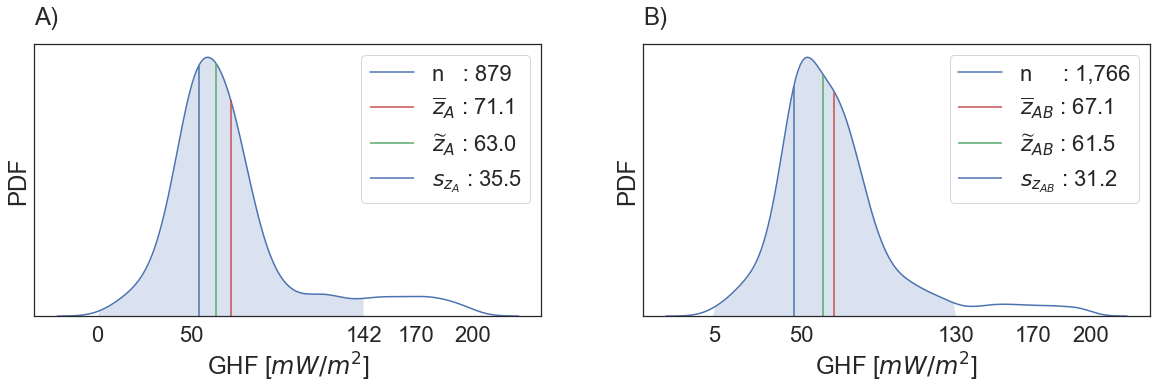

In [30]:
fig, axes = plt.subplots(1,2, figsize=(20, 5))
sub_figs = list('abcdefghijklmnopqrstuvwxyz')
sub_figs = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

# data is positvely skewed

sns.set(style='white', font_scale = 2)



#####
sns.kdeplot(hf_Afr_copy_ra_n[target], shade=False,  ax=axes[0], label=f'n   : {len(hf_Afr_copy_ra_n) :,}')

mean_a = "$\overline{z}_{A}$"
median_a = "$\widetilde{z}_{A}$"
std_a = "$s_{{z}_{A}}$"

kdeline = axes[0].lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

mean = hf_Afr_copy_ra_n[target].mean()
median = hf_Afr_copy_ra_n[target].median()
mode = hf_Afr_copy_ra_n[target].mode()
sdev = hf_Afr_copy_ra_n[target].std()
left = round(mean - 2*sdev,1)
right = round(mean + 2*sdev, 1)

axes[0].vlines(mean, 0, np.interp(mean, xs, ys),   label= f'{mean_a} : {round(mean,1)}',  color='r')
axes[0].vlines(median, 0, np.interp(median, xs, ys),  label= f'{median_a} : {round(median,2)}',  color='g')
#axes[0].vlines(mode, 0, np.interp(mode, xs, ys),  label= f'Mode : {round(mode[0],1)}',  color='b')
axes[0].vlines(mode, 0, np.interp(mode, xs, ys),  label= f'{std_a} : {round(sdev,1)}',  color='b')

axes[0].fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True,  alpha=0.2)


axes[0].set_ylim(ymin=0)

axes[0].legend()
#axes[0].axes.get_yaxis().set_visible(False)

axes[0].set_title(f'{sub_figs[0]})', loc ='left', pad=20)
#axes[0].set_xlabel('GHF  ($mW/m^{2}$)')

axes[0].set_xticks(np.round([right, 50,   left,  170, 200],0))
axes[0].set(xlabel='GHF [$mW/m^{2}$]', ylabel='PDF' )
axes[0].set_yticks([]) 
##

sns.kdeplot(hf_Afr_copy_rab_n[target], shade=False,  ax=axes[1], label=f'n     : {len(hf_Afr_copy_rab_n) :,}')

kdeline = axes[1].lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

mean_ab = "$\overline{z}_{AB}$"
median_ab = "$\widetilde{z}_{AB}$"
std_ab = "$s_{{z}_{AB}}$"

mean = hf_Afr_copy_rab_n[target].mean()
median = hf_Afr_copy_rab_n[target].median()
mode = hf_Afr_copy_rab_n[target].mode()
sdev = hf_Afr_copy_rab_n[target].std()
left = round(mean - 2*sdev, 1)
right = round(mean + 2*sdev, 1)

axes[1].vlines(mean, 0, np.interp(mean, xs, ys),   label= f'{mean_ab} : {round(mean,1)}',  color='r')
axes[1].vlines(median, 0, np.interp(median, xs, ys),  label= f'{median_ab} : {round(median,1)}',  color='g')
#axes[1].vlines(mode, 0, np.interp(mode, xs, ys),  label= f'Mode : {round(mode[0],2)}',  color='b')
axes[1].vlines(mode, 0, np.interp(mode, xs, ys),  label= f'{std_ab} : {round(sdev,1)}',  color='b')

axes[1].fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True,  alpha=0.2)


axes[1].set_ylim(ymin=0)

axes[1].legend(loc='upper right')

#axes[1].axes.get_yaxis().set_visible(False)
axes[1].set_yticks([]) 
axes[1].set_title(f'{sub_figs[1]})', loc ='left', pad=20)


axes[1].set(xlabel='GHF [$mW/m^{2}$]', ylabel='PDF' )
axes[1].set_xticks(np.round([ right, 50,   left,  170, 200],0))


plt.show()

fig.savefig(dir_p/'fig'/"fig_1a.jpeg", bbox_inches='tight', dpi=300 )


reorder covariates based on its corelation to traget to check for multicolinarity

# rating best

In [ ]:

hfs_dict = {
'hf_ra_n': hf_W_copy_ra_n[features_ghf], 
'hf_rab_n': hf_W_copy_rab_n[features_ghf],
}


for key, hf_tmp in hfs_dict.items() :
    print(key, end='\n')
    corr = hf_tmp.corr().abs().round(2)
    corr.sort_values(by=target, ascending=False, inplace=True)

    corr.drop(target, inplace=True)

    corr.index.to_list().append(target)

    columns_titles = corr.index.to_list()
    columns_titles.append(target)

    corr=corr.reindex(columns=columns_titles)


    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 6), dpi=300)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    obs_tmp = obs.set_index('OBS_REF')
    y_axis_labels = [obs_tmp.loc[feature, 'LABELS'] for feature in corr.index]

    x_axis_labels = copy.deepcopy(y_axis_labels)
    
    x_axis_labels.append('GHF')
    # Increase the size of the heatmap.
    #fig = plt.figure(num=None, figsize=(24, 12), dpi=300, facecolor='w', edgecolor='k')
    fig = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
    sns.set(font_scale=2.5)
    # Store heatmap object in a variable to easily access it when you want to include more features (such as title).
    # Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
    heatmap = sns.heatmap(corr, vmin=0, vmax=1, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Pearson Correlation Heatmap', fontdict={'fontsize':30}, pad=12);
    heatmap.tick_params(labelsize=30)
    
    #fig.savefig(dir_p/'fig'/"fig_s3.pdf", bbox_inches='tight', dpi=300 , pad_inches=0.2)




In [ ]:
sns.set_context( rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":30})   

for key, hf_tmp in hfs_dict.items() :
    print(key, end='\n')
    sns.pairplot(data = hf_tmp[features_ghf],            
                palette=sns.color_palette('coolwarm', n_colors=200) , corner=True)


In [ ]:
fig, ax = plt.subplots(4,4,figsize=(16,16),sharey=True)

axs = ax.flatten()

sns.set(style="whitegrid", color_codes=True, font_scale = 1.5)

for i, feature in enumerate(obs['OBS_REF']):

    unit = obs['UNITS'][i]
    label = obs['LABELS'][i]

    # An lmplot
    if feature in ['GLIM','REG']:

        g0 = sns.boxplot(x=hf_tmp[feature], y=hf_tmp[target], ax=axs[i], palette='bright')
        g0.set_xlabel(unit)
        axs[i].locator_params(axis='x', nbins=16/3)  # set divisor 
        axs[i].set(yticklabels=[])  

    else:
        #g0 = sns.scatterplot(x=hf_tmp[feature], y=hf_tmp[target],  ax=axs[i], size=1)
        g0 = sns.regplot(x=hf_tmp[feature], y=hf_tmp[target], ax=axs[i], 
                         scatter_kws= {'s':1} ,scatter=True)
        axs[i].set(yticklabels=[])  

        g0.set_xlabel(unit)
        legend_properties = {'weight':'bold','size':10}
        g0.legend(prop=legend_properties,loc='upper right', 
                   labels=[f'r$^2$ : {round(stats.pearsonr(hf_tmp[feature], hf_tmp[target])[0] ** 2,2)}'])


    if (i%4) ==0:
        g0.set_ylabel('GHF [mW/m2]')
        g0.xaxis.labelpad = 0
    else:
        #g0.set_ylabel('')
        g0.get_yaxis().set_visible(False)
        g0.xaxis.labelpad = 0
        #g0.spines['right'].set_visible(True)
        #g0.ax_joint.get_yaxis().set_visible(False) 

    if i%2 != 0:
        g0.xaxis.labelpad = 0
        g0.tick_params(axis="x",pad=12)
    else:
        g0.xaxis.labelpad = 0
        g0.tick_params(axis="x",pad=0)
        

    
    g0.set_title('(%s) %s'%(sub_figs[i],label), loc ='left', pad=50,  y=1.1)
    #g0.spines['right'].set_visible(False)

plt.subplots_adjust(hspace = 0.45, wspace=0)
plt.tight_layout()

plt.show()

#fig.savefig("fig_2.jpeg", bbox_inches='tight', dpi=300 , pad_inches=0)

In [ ]:
fig, ax = plt.subplots(4,4,figsize=(30,30),sharey=True)

axs = ax.flatten()

sns.set(style="whitegrid", color_codes=True, font_scale = 3)

for i, feature in enumerate(obs['OBS_REF']):

    unit = obs['UNITS'][i]
    label = obs['LABELS'][i]

    # An lmplot
    if feature in ['GLIM','REG']:

        g0 = sns.boxplot(x=hf_tmp[feature], y=hf_tmp[target], ax=axs[i], palette='bright')
        g0.set_xlabel(unit)
        axs[i].locator_params(axis='x', nbins=16/3)  # set divisor 


    else:
        #g0 = sns.scatterplot(x=hf_tmp[feature], y=hf_tmp[target],  ax=axs[i], size=1)
        g0 = sns.regplot(x=hf_tmp[feature], y=hf_tmp[target], ax=axs[i], 
                         scatter_kws= {'s':4, 'color':'grey'} ,scatter=True)


        g0.set_xlabel(unit)
        legend_properties = {'weight':'bold','size':30}
        g0.legend(prop=legend_properties,loc='upper right', 
                   labels=[f'r$^2$ : {round(stats.pearsonr(hf_tmp[feature], hf_tmp[target])[0] ** 2,2)}'])


    if (i%4) ==0:
        g0.set_ylabel('GHF [mW/m2]')
        g0.xaxis.labelpad = 0
    else:
        g0.set_ylabel('')
        g0.get_yaxis().set_visible(False)
        g0.xaxis.labelpad = 0
        #g0.spines['right'].set_visible(True)
        #g0.ax_joint.get_yaxis().set_visible(False) 
        
    if i%2 != 0:
        g0.xaxis.labelpad = 0
        g0.tick_params(axis="x",pad=12)
    else:
        g0.xaxis.labelpad = 0
        g0.tick_params(axis="x",pad=0)
        
    
    g0.set_title('(%s) %s'%(sub_figs[i],label), loc ='left', pad=50,  y=1.1)
    #g0.spines['right'].set_visible(False)

plt.subplots_adjust(hspace = 0, wspace=0)
plt.tight_layout()

#fig.savefig("fig_2.jpeg", bbox_inches='tight', dpi=300 , pad_inches=0)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()


#no need to correlate target with observable as they are not corelated
#kind : { "scatter" | "kde" | "hist" | "hex" | "reg" | "resid" }

for key, hf_tmp in hfs_dict.items() :
    fig = plt.figure(figsize=(13,8))
    gs = gridspec.GridSpec(4, 4)
    print(key)
    for i, feature in enumerate(obs['OBS_REF']):

                # An lmplot
        if feature in ['GLIM','REG']:
            g0 = sns.boxplot(x=hf_tmp[feature], y=hf_tmp[target], palette='bright')
            g1 = sns.violinplot(x=hf_tmp[feature], y=hf_tmp[target], palette='bright')
        else:

            # An lmplot
            g0 = sns.jointplot(hf_tmp[feature], hf_tmp[target], palette='bright',  kind="hex")
            # A PairGrid
            #g1 = sns.jointplot(data=hf_copy_rb[features_ex], x=feature, y=target,  palette='bright', kind='reg')

            g1 = sns.JointGrid(hf_tmp[feature], hf_tmp[target],  palette='bright');
            g1.plot(sns.regplot, sns.boxplot)

            legend_properties = {'weight':'bold','size':10}
            g1.ax_joint.legend(prop=legend_properties,loc='upper right', 
                           labels=[f'r$^2$ : {round(stats.pearsonr(hf_tmp[feature], hf_tmp[target])[0] ** 2,3)}'])
            # A FacetGrid



            fig = plt.figure(figsize=(13,8))
            gs = gridspec.GridSpec(1, 2)

            mg0 = SeabornFig2Grid(g0, fig, gs[0])
            mg1 = SeabornFig2Grid(g1, fig, gs[1])


            gs.tight_layout(fig)
        #gs.update(top=0.7)

        plt.show()

Biggest insight here is that all variables have a different scale, there are many outliers for most 
of them and no one seem really close to normality

# 5-Outlier detection

In [ ]:
rating = 'ra'
#outlier = 'NOD'
outlier = 'OD'



file_label = f'{outlier}_{rating}'



training_w_sod  =   dir_p /'data'/'dataset'/'Preprocessed'/f'Training_W_{file_label}.csv'
training_afr_sod = dir_p /'data'/'dataset'/'Preprocessed'/f'Training_Afr_{file_label}.csv'




# Initiate parameter grid

# param distribution
n_estimators      = np.arange(100, 800,50)
max_features = np.arange(1,16) 
#the maximum number of features Random Forest is allowed to try in individual tree

bootstrap    = [True, False] # deafult is false for extra trees True for randomforest
contamination = np.arange(0.0001, 0.12, 0.0001)

# updated param distribution
#n_estimators      = Integer(150, 500)#  BEST 100

max_samples =  np.arange(100, 4000, 5)

random_state = 42

hyperparameters = {}


# Update dict with Extra Trees
hyperparameters.update({"IF": { 
                             'detector__n_estimators': n_estimators,  # # inc up to a point then overfit train reduce test
    
                             'detector__bootstrap': bootstrap,
                             #'detector__ccp_alpha':[ 0.0],
    
                             'detector__contamination': contamination, # inc up to a point then overfit train reduce test
    
                             'detector__max_features': max_features,  # # inc up to a point then overfit train reduce test
                             'detector__max_samples': max_samples, 
                           
                                             }})


hfs = [hf_W_copy_ra_n, hf_Afr_copy_ra_n,  ]
regions = ['W', 'Afr',]
file_outs = [training_w_sod , training_afr_sod,  ]



for hf, region, file_out in zip(hfs, regions, file_outs):
    
    
    X_train = hf[features]
    y_train = hf[target]

    # Initialize dictionary to store results
    results = {}

    kfold = 5

    cv = KFold(n_splits=kfold, random_state=random_state,  shuffle=True)
    n_iter = 50


    # Tune and evaluate detectors
    detector_label = 'IF'

    # Print message to user
    print('#'*60)
    print(f"Now tuning {detector_label} for {region}.")

    def scorer_f(estimator, X):   #your own scorer
          return np.mean(estimator.score_samples(X)) *-1


    #scoring = make_scorer(nrmse , greater_is_better=False )
    #scoring = make_scorer(r2_normalized, greater_is_better=True)
    #scoring = make_scorer(scorer_f, greater_is_better=True)
    scoring = make_scorer(mean_squared_error,squared=False, greater_is_better=False)

    # Scale features via Z-score normalization
    #scaler = StandardScaler()
    #scaler= RobustScaler()

    detector = IsolationForest(random_state=random_state)
    
    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)

    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )


    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("detector", detector)]

    pipeline_bscv = Pipeline(steps = steps)
    

    # Define parameter grid
    search_space = hyperparameters[detector_label]

    # Initialize BaysSearch object                  
    bscv = BayesSearchCV(
        pipeline_bscv,
        # (parameter space, # of evaluations)f
        search_space,
        n_iter = n_iter, 
        cv = cv, 
        #verbose = 3, 
        n_jobs= -1, 
        scoring= scorer_f ,
        return_train_score=True,
        refit=True,
        random_state=random_state,
    )

    # Fit gscv
    bscv.fit(X_train)  

    # Get best parameters and score
    best_params = bscv.best_params_
    best_score = bscv.best_score_


    print(f'Optimization has terminated for {region}.')
   

    #save results
    bs_if_hyp  =  dir_p/'Hyperparameters'/f'IF_hyper_{region}_{file_label}.csv'

    dropped_columns = ['mean_fit_time', 'std_fit_time',  'params', 'mean_score_time', 'std_score_time']

    # all hyp results
    # gives traing and validation results
    bs_df = pd.DataFrame(bscv.cv_results_)

    bs_df = bs_df.sort_values(f'rank_test_score', ascending=True).reset_index(drop=True)

    bs_df['mean_test_score'] = bs_df['mean_test_score'] 
    bs_df['mean_train_score'] = bs_df['mean_train_score'] 

    split_test = [f'split{x}_test_score' for x in range(kfold)]
    split_train = [f'split{x}_train_score' for x in range(kfold)]

    dropped_columns.extend(split_test)
    dropped_columns.extend(split_train)

    bs_df = bs_df.drop(dropped_columns, axis=1)


    bs_df.to_csv(bs_if_hyp , sep='\t')

    

    #import shap

    sns.set_theme(style="white", font_scale=2)

    def IForest(df, k=1.5):

        idx = copy.deepcopy(features_ghf)

        X = df[features]
        y =  df[target]

        X_if = df[idx]


        IF = IsolationForest(random_state=random_state)
        
        
        ## ranked 1
        
        tuned_param_rank_1 = {item[10:]: best_params[item] for item in best_params}
        IF.set_params(**tuned_param_rank_1 )
        IF.fit(X.values)
        anomaly_decison_rank_1 =  IF.decision_function(X.values)
        anomalies_rank_1  = IF.predict(X.values) 
        scores_rank_1  = IF.score_samples(X.values)
        parameters_rank_1 =IF.get_params()

        # manual and automatic
        tuned_params = {
             'bootstrap': bs_df.loc[0:5, 'param_detector__bootstrap'].mode()[0],
            'contamination': bs_df.loc[0:5, 'param_detector__contamination'].min(),
            'max_features': bs_df.loc[0:5, 'param_detector__max_features'].min(),
            'max_samples': bs_df.loc[0:5, 'param_detector__max_samples'].min(),
            'n_estimators': bs_df.loc[0:5, 'param_detector__n_estimators'].min()
        }
        IF.set_params(**tuned_params)
        IF.fit(X.values)
        anomaly_decison =  IF.decision_function(X.values)
        anomalies = IF.predict(X.values) 
        scores = IF.score_samples(X.values)
        
        #print(IF.get_params())

        mask = anomalies == -1
        X_train_iforest, y_train_iforest = X.values[~mask, :], y.values[~mask]
        #X.values_if.columns = 
        #print(anomalies.shape)



        X_if['scores'] = scores
        X_if['anomaly'] = anomalies

        q1 = X_if['scores'].quantile(0.25)
        q3 = X_if['scores'].quantile(0.75)
        iqr = q3 - q1
        lower_bound=(q1 - k * iqr)
        upper_bound=(q3 + k * iqr)
        
        print('for Automatic optimization')
        #print("Lower bound:{} \nUpper bound:{}".format(lower_bound,upper_bound))

        anomolus_dp = X.values[np.where(anomalies == -1, True, False)]
        print("\nThe data has {} anomolus points and the data points are the following for  : ".format(len(anomolus_dp)))
        print("Percentage of anomalies in data: {:.2f}".format((len(anomolus_dp)/len(X.values))*100))
        #print(anomolus_dp)

      
       #####
        hf_tmp = X_if[X_if['anomaly'] ==-1][idx]
        corr_tuned = hf_tmp.corr().abs()
        corr_tuned.sort_values(by = target, ascending=False, inplace=True)

        corr_tuned.drop(target, inplace=True)

        corr_tuned.index.to_list().append(target)

        columns_titles = corr_tuned.index.to_list()
        columns_titles.append(target)

        corr_tuned=corr_tuned.reindex(columns=columns_titles)

        obs_tmp = obs.set_index('OBS_REF')
        y_axis_labels = [obs_tmp.loc[feature, 'LABELS'] for feature in corr_tuned.index]

        x_axis_labels = copy.deepcopy(y_axis_labels)

        x_axis_labels.append('GHF')
        # Increase the size of the heatmap.
        fig = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
       
        heatmap = sns.heatmap(corr_tuned, vmin=0, vmax=1, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
        heatmap.set_title('Pearson Correlation Heatmap after optimization', fontdict={'fontsize':12}, pad=12);

         ######

        hf_tmp = X_if[idx]
        corr = hf_tmp.corr().abs()
        corr.sort_values(by = target, ascending=False, inplace=True)

        corr.drop(target, inplace=True)

        corr.index.to_list().append(target)

        columns_titles = corr.index.to_list()
        columns_titles.append(target)

        corr=corr.reindex(columns=columns_titles)

        obs_tmp = obs.set_index('OBS_REF')
        y_axis_labels = [obs_tmp.loc[feature, 'LABELS'] for feature in corr.index]

        x_axis_labels = copy.deepcopy(y_axis_labels)

        x_axis_labels.append('GHF')
        # Increase the size of the heatmap.
        fig = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')

        

        heatmap = sns.heatmap(corr, vmin=0, vmax=1, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
        heatmap.set_title('Pearson Correlation Heatmap before optimization', fontdict={'fontsize':12}, pad=12);
        plt.show()
        ######
        
        
        
        print('Without outlier detection')
        print(f'r2 before : {round(corr[target].sum(),3)}, mean : {round(corr[target].sum()/len(X.columns),3)}\n')
        print(f' < 0.1 : {len(corr[corr[target] < 0.15])}')
        print(f' > 0.5 : {len(corr[corr[target] > 0.5])}')
        print('#'*20)
        print('Ranked 1 best paramter and score')
        print(f'score :  {round(np.mean(scores_rank_1),5)*-1}')
        print(f'parameter : {parameters_rank_1}\n')
        print('#'*20)
        print('Automatic tuned paramter and score')
        print(f'r2 : {round(corr_tuned[target].sum(),3)}, mean : {round(corr_tuned[target].sum()/len(X.columns),3)}')
        print(f'score :  {round(np.mean(scores)*-1,5)}')
        print(f' < 0.1 : {len(corr_tuned[corr_tuned[target] < 0.15])}')
        print(f' > 0.5 : {len(corr_tuned[corr_tuned[target] > 0.5])}')
        print(f'parameter : {tuned_params}\n')

        
        #####
        print("\n Offset for Isolation forest")
        print(IF.offset_)

        sns.histplot(anomaly_decison, bins=10)
        plt.show()
        ######
        sns.histplot(np.sort(scores), bins=10)
        plt.show()
        
        bs_if_hyp =  dir_p/'Hyperparameters'/f'IF_{region}_{file_label}.csv'


        bs_if_hyp_df = pd.DataFrame.from_dict([tuned_params])


        bs_if_hyp_df.to_csv(bs_if_hyp , index=False, sep='\t')


        hf_tmp_csv =  df[~mask].sort_values(by=['lon', 'lat'], ascending=True).reset_index(drop=False)
        hf_tmp_csv.to_csv(file_out , index=False, header=True, sep='\t')
        
        
        
        
        return



    IForest(hf, k=2)

    ## save files 




rating best removed N

############################################################
Now tuning IF for W.
Optimization has terminated for W.
for Automatic optimization
Lower bound:-0.5273537832717932 
Upper bound:-0.42462102158474463

The data has 29 anomolus points and the data points are the following for  : 
Percentage of anomalies in data: 0.23
Without outlier detection
r2 before : 3.019, mean : 0.189

 < 0.1 : 6
 < 0.5 : 0
####################
Ranked 1 best paramter and score
score :  0.48014
parameter : {'bootstrap': True, 'contamination': 0.0023, 'max_features': 1, 'max_samples': 3540, 'n_estimators': 100, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False}

####################
Automatic tuned paramter and score
r2 : 6.158, mean : 0.385
score :  0.47665
 < 0.1 : 3
 < 0.5 : 8
parameter : {'bootstrap': True, 'contamination': 0.0023, 'max_features': 1, 'max_samples': 2315, 'n_estimators': 100}


 Offset for Isolation forest
-0.5471721760007113


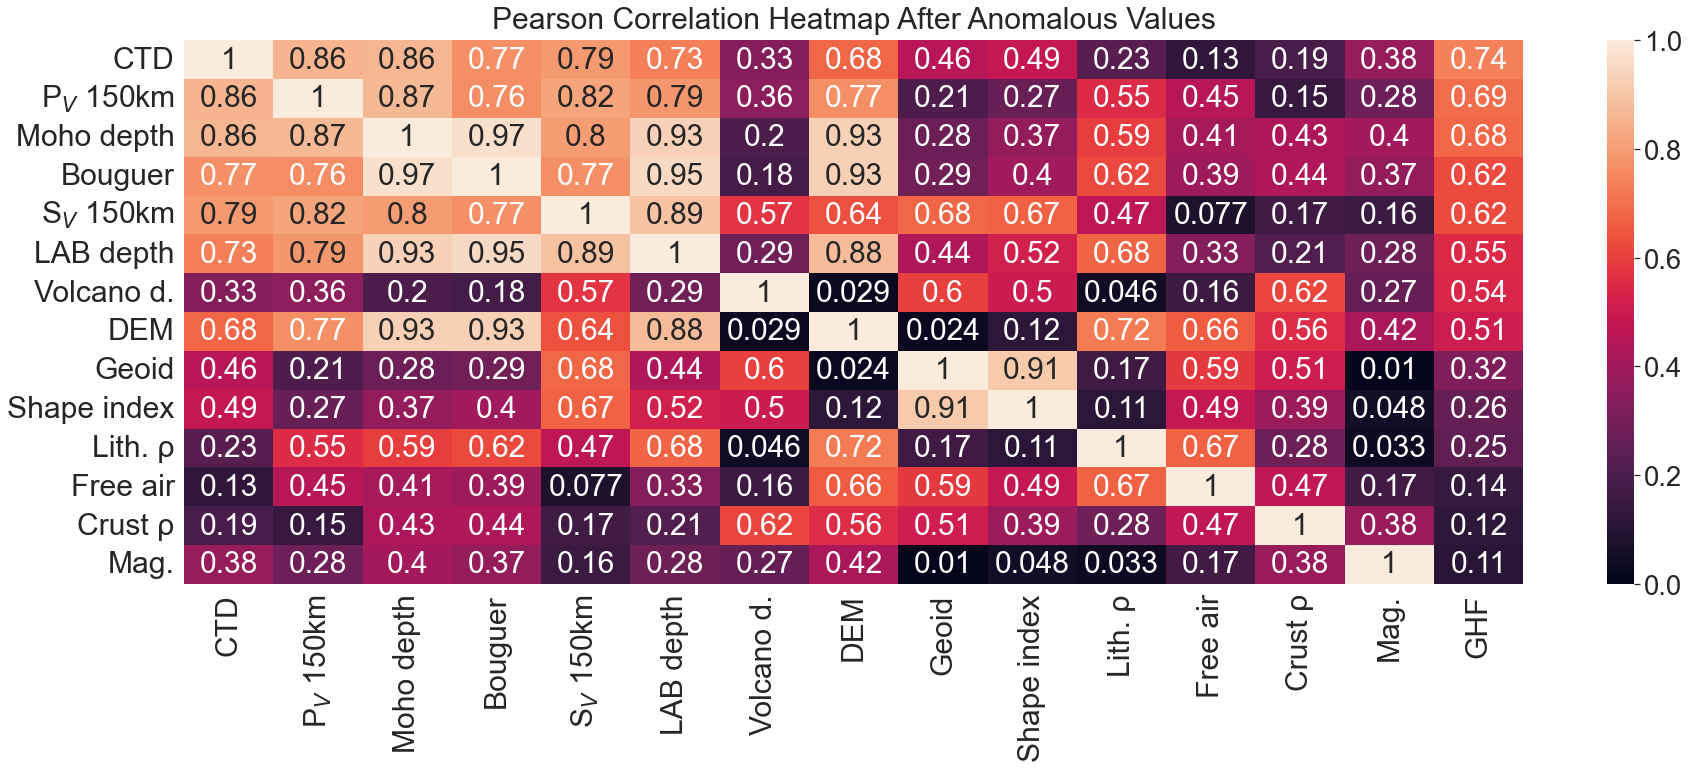

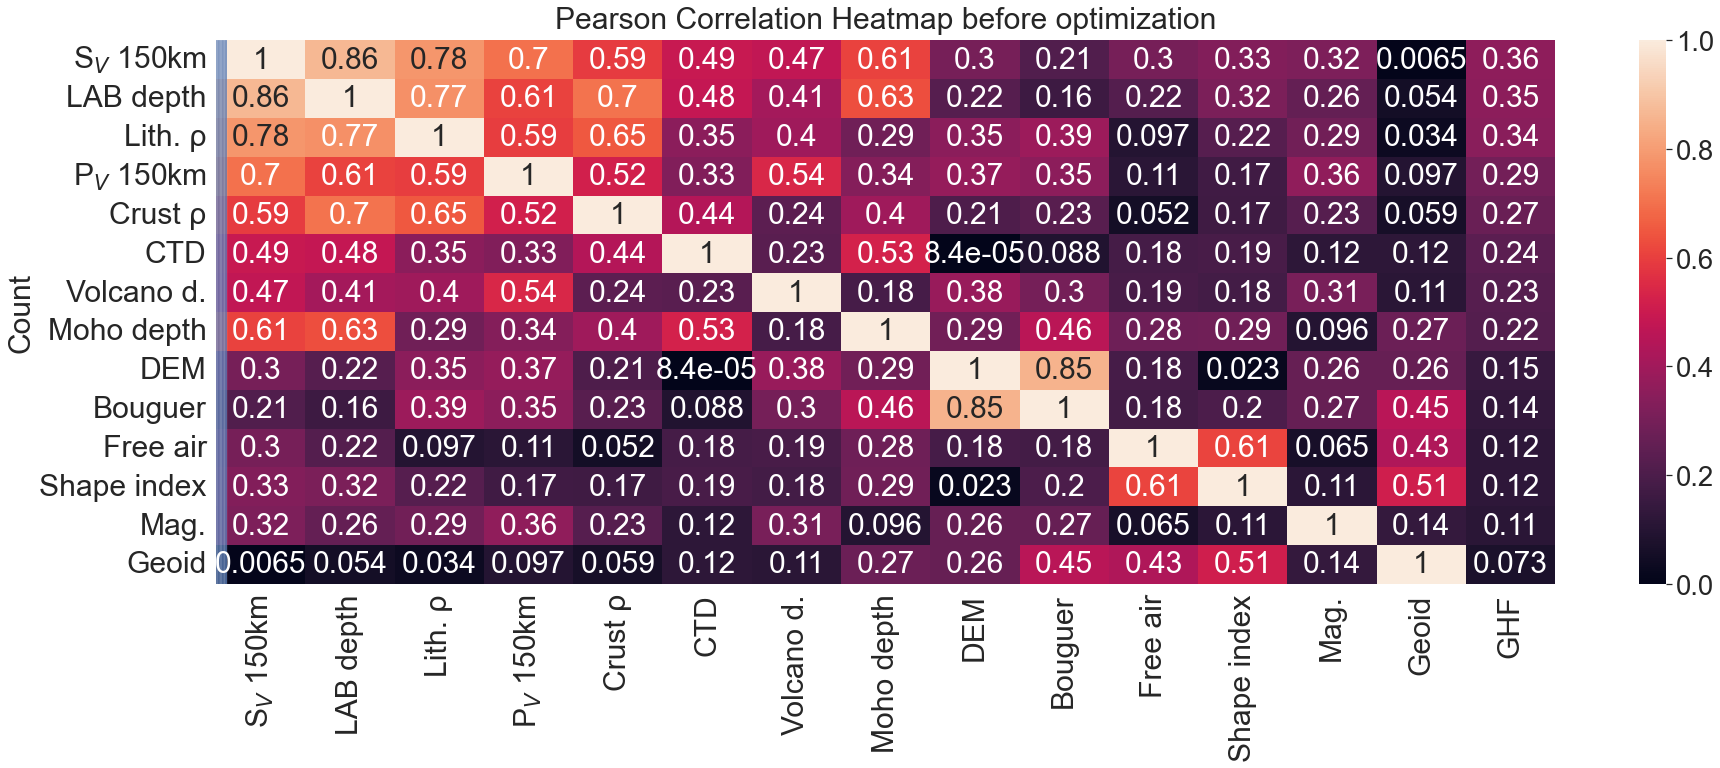

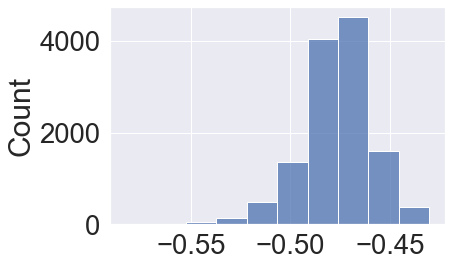

############################################################
Now tuning IF for Afr.
Optimization has terminated for Afr.
for Automatic optimization
Lower bound:-0.6593439439592841 
Upper bound:-0.32005140504498986

The data has 67 anomolus points and the data points are the following for  : 
Percentage of anomalies in data: 3.79
Without outlier detection
r2 before : 1.549, mean : 0.097

 < 0.1 : 10
 < 0.5 : 0
####################
Ranked 1 best paramter and score
score :  0.49089
parameter : {'bootstrap': True, 'contamination': 0.08760000000000001, 'max_features': 1, 'max_samples': 3360, 'n_estimators': 100, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False}

####################
Automatic tuned paramter and score
r2 : 3.564, mean : 0.223
score :  0.48994
 < 0.1 : 4
 < 0.5 : 0
parameter : {'bootstrap': True, 'contamination': 0.0386, 'max_features': 1, 'max_samples': 1560, 'n_estimators': 100}


 Offset for Isolation forest
-0.5517361691592371


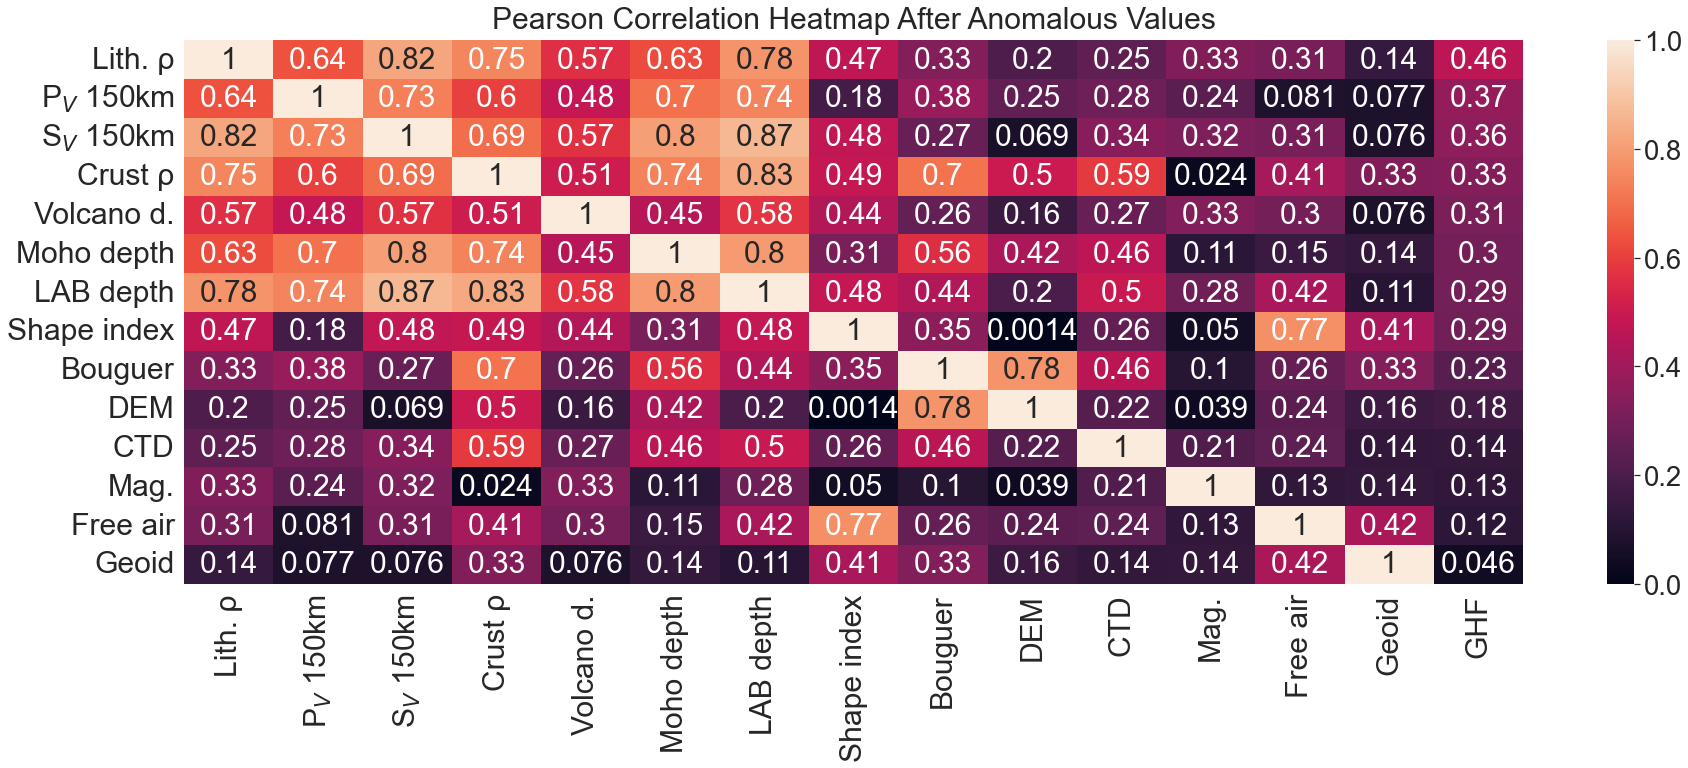

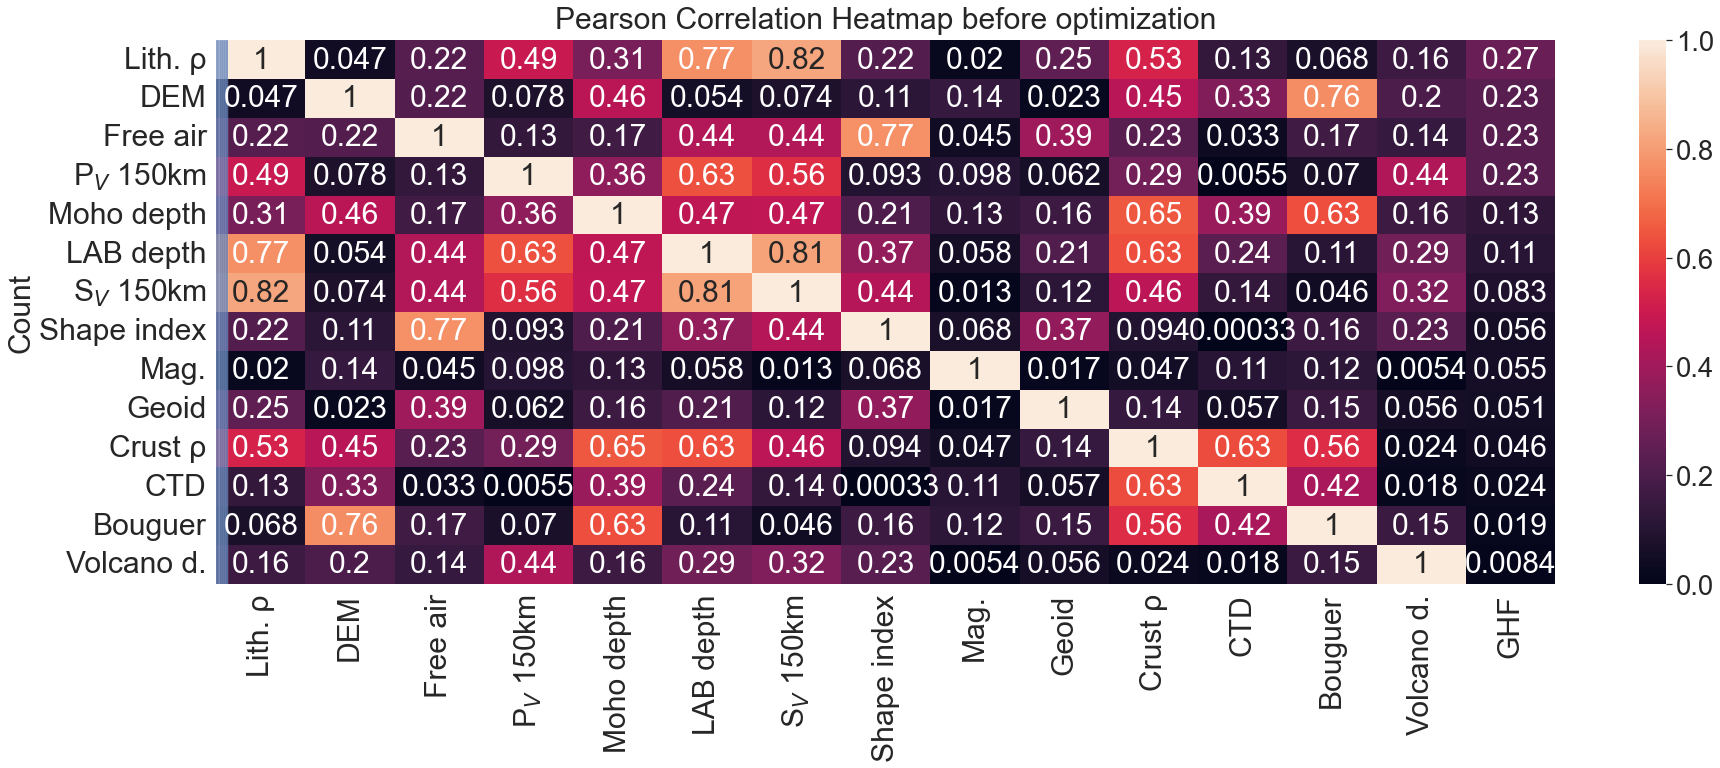

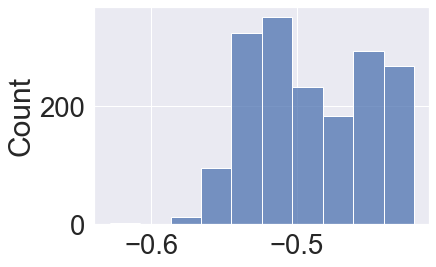

In [31]:

rating = 'rab'
#outlier = 'NOD'
outlier = 'OD'


file_label = f'{outlier}_{rating}'



training_w_sod  =   dir_p /'data'/'dataset'/'Preprocessed'/f'Training_W_{file_label}.csv'
training_afr_sod = dir_p /'data'/'dataset'/'Preprocessed'/f'Training_Afr_{file_label}.csv'


# Initiate parameter grid

# param distribution
n_estimators      = np.arange(100, 800,50)
max_features = np.arange(1,16) 
#the maximum number of features Random Forest is allowed to try in individual tree

bootstrap    = [True, False] # deafult is false for extra trees True for randomforest
contamination = np.arange(0.0001, 0.12, 0.0001)

# updated param distribution
#n_estimators      = Integer(150, 500)#  BEST 100

max_samples =  np.arange(100, 4000, 5)



hyperparameters = {}


# Update dict with Extra Trees
hyperparameters.update({"IF": { 
                             'detector__n_estimators': n_estimators,  # # inc up to a point then overfit train reduce test
    
                             'detector__bootstrap': bootstrap,
                             #'detector__ccp_alpha':[ 0.0],
    
                             'detector__contamination': contamination, # inc up to a point then overfit train reduce test
    
                             'detector__max_features': max_features,  # # inc up to a point then overfit train reduce test
                             'detector__max_samples': max_samples, 
                           
                                             }})


hfs = [hf_W_copy_rab_n, hf_Afr_copy_rab_n,   ]
regions = ['W', 'Afr',  ]
file_outs = [training_w_sod , training_afr_sod, ]


for hf, region, file_out in zip(hfs, regions, file_outs):
    
    X_train = hf[features]
    y_train = hf[target]

    # Initialize dictionary to store results
    results = {}

    kfold = 5

    cv = KFold(n_splits=kfold, random_state=42, shuffle=True)
    n_iter = 50


    # Tune and evaluate detectors
    detector_label = 'IF'

    # Print message to user
    print('#'*60)
    print(f"Now tuning {detector_label} for {region}.")

    def scorer_f(estimator, X):   #your own scorer
          return np.mean(estimator.score_samples(X)) *-1


    #scoring = make_scorer(nrmse , greater_is_better=False )
    #scoring = make_scorer(r2_normalized, greater_is_better=True)
    scoring = make_scorer(scorer_f, greater_is_better=True)

    # Scale features via Z-score normalization
    #scaler = StandardScaler()
    #scaler= RobustScaler()

    detector = IsolationForest(random_state=42)

    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("detector", detector)]

    pipeline_bscv = Pipeline(steps = steps)


    # Define parameter grid
    search_space = hyperparameters[detector_label]

    # Initialize BaysSearch object                  
    bscv = BayesSearchCV(
        pipeline_bscv,
        # (parameter space, # of evaluations)
        search_space,
        n_iter = n_iter, 
        cv = cv, 
        #verbose = 3, 
        n_jobs= -1, 
        scoring= scorer_f,
        return_train_score=True,
        refit=True,
        random_state=42,
    )

    # Fit gscv
    bscv.fit(X_train)  

    # Get best parameters and score
    best_params = bscv.best_params_
    best_score = bscv.best_score_


    print(f'Optimization has terminated for {region}.')
   

    #save results
    bs_if_hyp  =  dir_p/'Hyperparameters'/f'IF_hyper_{region}_{file_label}.csv'

    dropped_columns = ['mean_fit_time', 'std_fit_time',  'params', 'mean_score_time', 'std_score_time']

    # all hyp results
    # gives traing and validation results
    bs_df = pd.DataFrame(bscv.cv_results_)

    bs_df = bs_df.sort_values(f'rank_test_score', ascending=True).reset_index(drop=True)

    bs_df['mean_test_score'] = bs_df['mean_test_score'] 
    bs_df['mean_train_score'] = bs_df['mean_train_score'] 

    split_test = [f'split{x}_test_score' for x in range(kfold)]
    split_train = [f'split{x}_train_score' for x in range(kfold)]

    dropped_columns.extend(split_test)
    dropped_columns.extend(split_train)

    bs_df = bs_df.drop(dropped_columns, axis=1)


    bs_df.to_csv(bs_if_hyp , sep='\t')

    

    #import shap

    sns.set_theme(style="white", font_scale=2)

    def IForest(df, k=1.5):

        idx = copy.deepcopy(features_ghf)

        X = df[features]
        y =  df[target]

        X_if = df[idx]


        IF = IsolationForest(random_state=42)
        
        
        ## ranked 1
        
        tuned_param_rank_1 = {item[10:]: best_params[item] for item in best_params}
        IF.set_params(**tuned_param_rank_1 )
        IF.fit(X.values)
        anomaly_decison_rank_1 =  IF.decision_function(X.values)
        anomalies_rank_1  = IF.predict(X.values) 
        scores_rank_1  = IF.score_samples(X.values)
        parameters_rank_1 =IF.get_params()

        # manual and automatic
        tuned_params = {
             'bootstrap': bs_df.loc[0:5, 'param_detector__bootstrap'].mode()[0],
            'contamination': bs_df.loc[0:5, 'param_detector__contamination'].min(),
            'max_features': bs_df.loc[0:5, 'param_detector__max_features'].min(),
            'max_samples': bs_df.loc[0:5, 'param_detector__max_samples'].min(),
            'n_estimators': bs_df.loc[0:5, 'param_detector__n_estimators'].min()
        }
        IF.set_params(**tuned_params)
        IF.fit(X.values)
        anomaly_decison =  IF.decision_function(X.values)
        anomalies = IF.predict(X.values) 
        scores = IF.score_samples(X.values)
        
        #print(IF.get_params())

        mask = anomalies == -1
        X_train_iforest, y_train_iforest = X.values[~mask, :], y.values[~mask]
        #X.values_if.columns = 
        #print(anomalies.shape)



        X_if['scores'] = scores
        X_if['anomaly'] = anomalies

        q1 = X_if['scores'].quantile(0.25)
        q3 = X_if['scores'].quantile(0.75)
        iqr = q3 - q1
        lower_bound=(q1 - k * iqr)
        upper_bound=(q3 + k * iqr)
        
        print('for Automatic optimization')
        print("Lower bound:{} \nUpper bound:{}".format(lower_bound,upper_bound))

        anomolus_dp = X.values[np.where(anomalies == -1, True, False)]
        print("\nThe data has {} anomolus points and the data points are the following for  : ".format(len(anomolus_dp)))
        print("Percentage of anomalies in data: {:.2f}".format((len(anomolus_dp)/len(X.values))*100))
        #print(anomolus_dp)

      
       #####
        
        sns.set(font_scale=2.5)
        hf_tmp = X_if[X_if['anomaly'] ==-1][idx]
        corr_tuned = hf_tmp.corr().abs()
        corr_tuned.sort_values(by = target, ascending=False, inplace=True)

        corr_tuned.drop(target, inplace=True)

        corr_tuned.index.to_list().append(target)

        columns_titles = corr_tuned.index.to_list()
        columns_titles.append(target)

        corr_tuned=corr_tuned.reindex(columns=columns_titles)

        obs_tmp = obs.set_index('OBS_REF')
        y_axis_labels = [obs_tmp.loc[feature, 'LABELS'] for feature in corr_tuned.index]

        x_axis_labels = copy.deepcopy(y_axis_labels)

        x_axis_labels.append('GHF')
        # Increase the size of the heatmap.
        fig = plt.figure(num=None, figsize=(30, 10), facecolor='w', edgecolor='k')
       
        heatmap = sns.heatmap(corr_tuned, vmin=0, vmax=1, annot=True,
                              xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
        heatmap.set_title('Pearson Correlation Heatmap After Anomalous Values', 
                          fontdict={'fontsize':30}, pad=12);
        heatmap.tick_params(labelsize=30)

        fig.savefig(dir_p/'fig'/"fig_s4.pdf", bbox_inches='tight', dpi=300 , pad_inches=0.1)        
        fig.savefig(dir_p/'fig'/"fig_s4.jpg", bbox_inches='tight', dpi=300 , pad_inches=0.1)
         ######
            

        hf_tmp = X_if[idx]
        corr = hf_tmp.corr().abs()
        corr.sort_values(by = target, ascending=False, inplace=True)

        corr.drop(target, inplace=True)

        corr.index.to_list().append(target)

        columns_titles = corr.index.to_list()
        columns_titles.append(target)

        corr=corr.reindex(columns=columns_titles)

        obs_tmp = obs.set_index('OBS_REF')
        y_axis_labels = [obs_tmp.loc[feature, 'LABELS'] for feature in corr.index]

        x_axis_labels = copy.deepcopy(y_axis_labels)

        x_axis_labels.append('GHF')
        # Increase the size of the heatmap.
        fig = plt.figure(num=None, figsize=(30, 10), facecolor='w', edgecolor='k')

        

        heatmap = sns.heatmap(corr, vmin=0, vmax=1, annot=True,
                              xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
        heatmap.set_title('Pearson Correlation Heatmap before optimization', 
                          fontdict={'fontsize':30}, pad=12);
        heatmap.tick_params(labelsize=30)
        #fig.savefig(dir_p/'fig'/"fig_s3.jpeg", bbox_inches='tight', dpi=300 , pad_inches=0.1)
        ######
        
        print('Without outlier detection')
        print(f'r2 before : {round(corr[target].sum(),3)}, mean : {round(corr[target].sum()/len(X.columns),3)}\n')
        print(f' < 0.1 : {len(corr[corr[target] < 0.15])}')
        print(f' < 0.5 : {len(corr[corr[target] > 0.5])}')
        print('#'*20)
        print('Ranked 1 best paramter and score')
        print(f'score :  {round(np.mean(scores_rank_1),5)*-1}')
        print(f'parameter : {parameters_rank_1}\n')
        print('#'*20)
        print('Automatic tuned paramter and score')
        print(f'r2 : {round(corr_tuned[target].sum(),3)}, mean : {round(corr_tuned[target].sum()/len(X.columns),3)}')
        print(f'score :  {round(np.mean(scores)*-1,5)}')
        print(f' < 0.1 : {len(corr_tuned[corr_tuned[target] < 0.15])}')
        print(f' < 0.5 : {len(corr_tuned[corr_tuned[target] > 0.5])}')
        print(f'parameter : {tuned_params}\n')

        
        #####
        print("\n Offset for Isolation forest")
        print(IF.offset_)

        sns.histplot(anomaly_decison, bins=10)
        plt.show()
        ######
        sns.histplot(np.sort(scores), bins=10)
        plt.show()
        
        bs_if_hyp =  dir_p/'Hyperparameters'/f'IF_{region}_{file_label}.csv'


        bs_if_hyp_df = pd.DataFrame.from_dict([tuned_params])


        bs_if_hyp_df.to_csv(bs_if_hyp , index=False, sep='\t')

        

        hf_tmp_csv =  df[~mask].sort_values(by=['lon', 'lat'], ascending=True).reset_index(drop=False)
        hf_tmp_csv.to_csv(file_out , index=False, header=True, sep='\t')
        
        return



    IForest(hf, k=2)



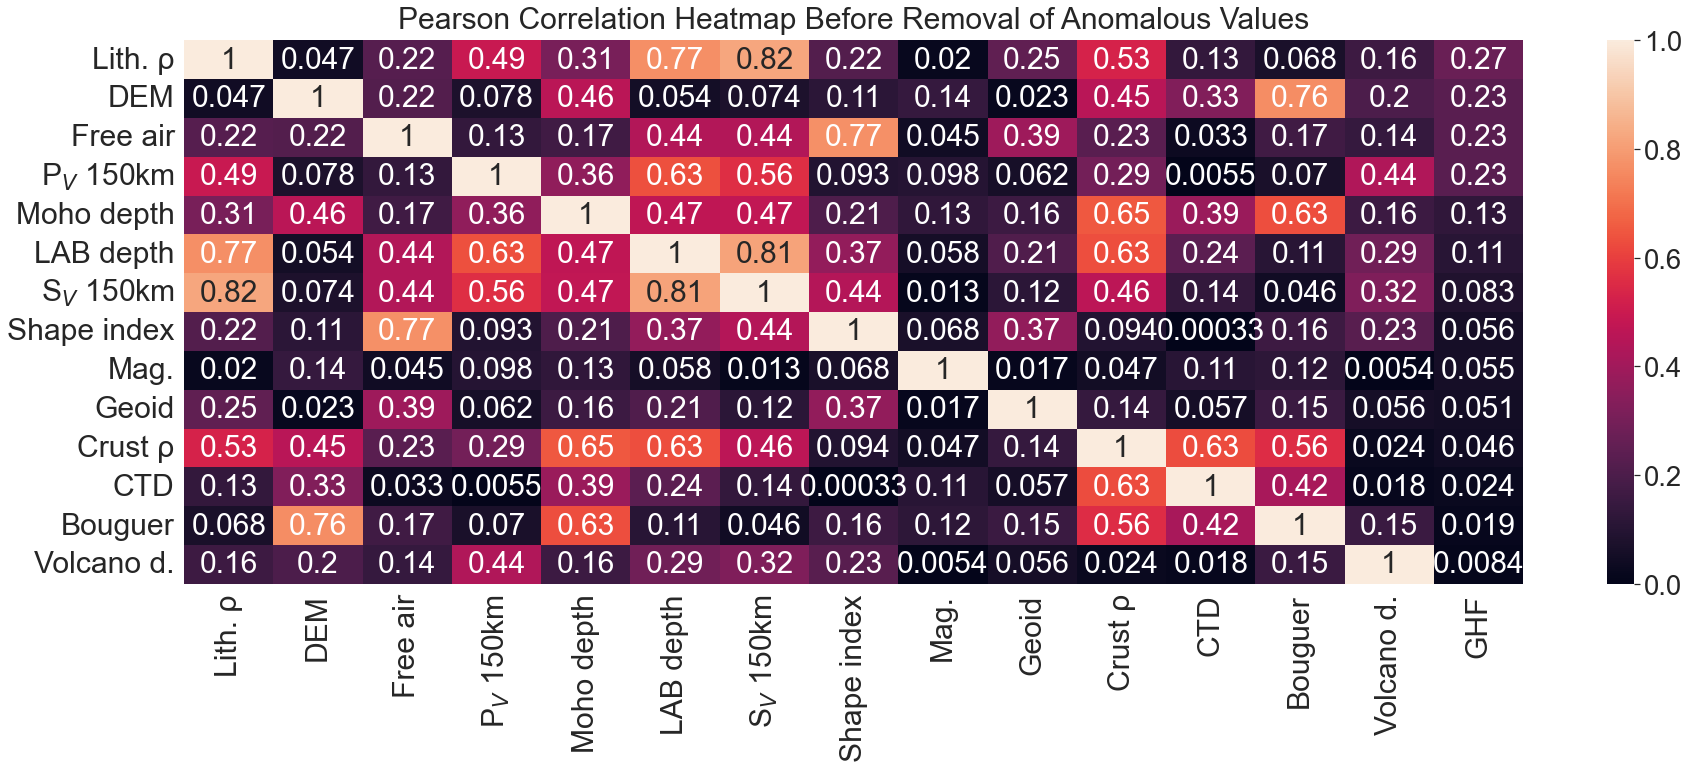

In [34]:
idx = copy.deepcopy(features_ghf)


X_if = hf_Afr_copy_rab_n[idx]
hf_tmp = X_if[idx]
corr = hf_tmp.corr().abs()
corr.sort_values(by = target, ascending=False, inplace=True)

corr.drop(target, inplace=True)

corr.index.to_list().append(target)

columns_titles = corr.index.to_list()
columns_titles.append(target)

corr=corr.reindex(columns=columns_titles)

obs_tmp = obs.set_index('OBS_REF')
y_axis_labels = [obs_tmp.loc[feature, 'LABELS'] for feature in corr.index]

x_axis_labels = copy.deepcopy(y_axis_labels)

x_axis_labels.append('GHF')
# Increase the size of the heatmap.
fig = plt.figure(num=None, figsize=(30, 10), facecolor='w', edgecolor='k')



heatmap = sns.heatmap(corr, vmin=0, vmax=1, annot=True,
                      xticklabels=x_axis_labels, yticklabels=y_axis_labels)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Pearson Correlation Heatmap Before Removal of Anomalous Values', 
                  fontdict={'fontsize':30}, pad=12);
heatmap.tick_params(labelsize=30)
fig.savefig(dir_p/'fig'/"fig_s3.pdf", bbox_inches='tight', dpi=300 , pad_inches=0.1)
fig.savefig(dir_p/'fig'/"fig_s3.jpg", bbox_inches='tight', dpi=300 , pad_inches=0.1)

In [ ]:
hf_tmp

rating good clipped

In [39]:
hf_Afr_copy_rab_n

SI         LAB       MOHO        CTD        SV        PV      GEOID         FA        RHO_C          BG  EMAG2_CLASS     DEM        RHO_L  VOLC_DIST_W REG GLIM     lon     lat  grid_index  heat-flow (mW/m2)
0     0.933484  112.976530  25.708034  22.507461  0.010021 -0.007703  28.777662  16.009990  2791.351466  102.194300     0.060112    28.0  3335.865830     0.877958   6    3 -17.450  14.750       14837         66.8      
1     0.933484  112.976530  25.708034  22.507461  0.010021 -0.007703  28.777662  16.009990  2791.351466  102.194300     0.060112    28.0  3335.865830     0.877958   6    3 -17.433  14.683       14837         81.0      
2     0.933484  112.976530  25.708034  22.507461  0.010021 -0.007703  28.777662  16.009990  2791.351466  102.194300     0.060112    28.0  3335.865830     0.877958   6    3 -17.433  14.717       14837         73.2      
3     0.933484  112.976530  25.708034  22.507461  0.010021 -0.007703  28.777662  16.009990  2791.351466  102.194300     0.060112    28.0  3335.865830     0.877958   6    3 -17.433  14.733       14837         78.5      
4     0.933484  112.976530  25.708034  22.507461  0.010021 -0.007703  28.777662  16.009990  2791.351466  102.194300     0.060112    28.0  3335.865830     0.877958   6    3 -17.417  14.700       14837         67.7      
...        ...         ...        ...        ...       ...       ...        ...        ...          ...         ...          ...     ...          ...          ...  ..  ...     ...     ...         ...          ...      
1761  0.766193   69.261390  29.088212  19.348889  0.003610 -0.010940 -28.031926  52.847828  2780.624135  -21.886982    -0.003435  1177.0  3285.211875     0.000000   2    6  49.750  10.667       13819         59.0      
1762 -0.320319   82.167650  26.317240  21.403241  0.033617 -0.010427 -37.404268  10.330066  2816.476783   38.892787     0.029141   287.0  3304.783153     0.000000   2    6  50.517   9.550       13388         59.0      
1763 -0.320319   82.167650  26.317240  21.403241  0.033617 -0.010427 -37.404268  10.330066  2816.476783   38.892787     0.029141   287.0  3304.783153     0.000000   2    6  50.667   9.417       13388         59.0      
1764 -0.155005   72.119747  24.509425  20.786140  0.021729 -0.010764 -33.291200   7.114842  2780.455822   14.922675     0.016540   242.0  3282.138780     0.000000   2    1  51.000  10.617       13821         54.0      
1765  0.555865   92.916624  45.719106  34.895088  0.008880 -0.001631   4.216432  87.330399  2748.178304 -107.664819     0.052052   969.0  3268.605545     0.000000   3    6  51.617  35.667       20878         88.0      

[1766 rows x 20 columns]

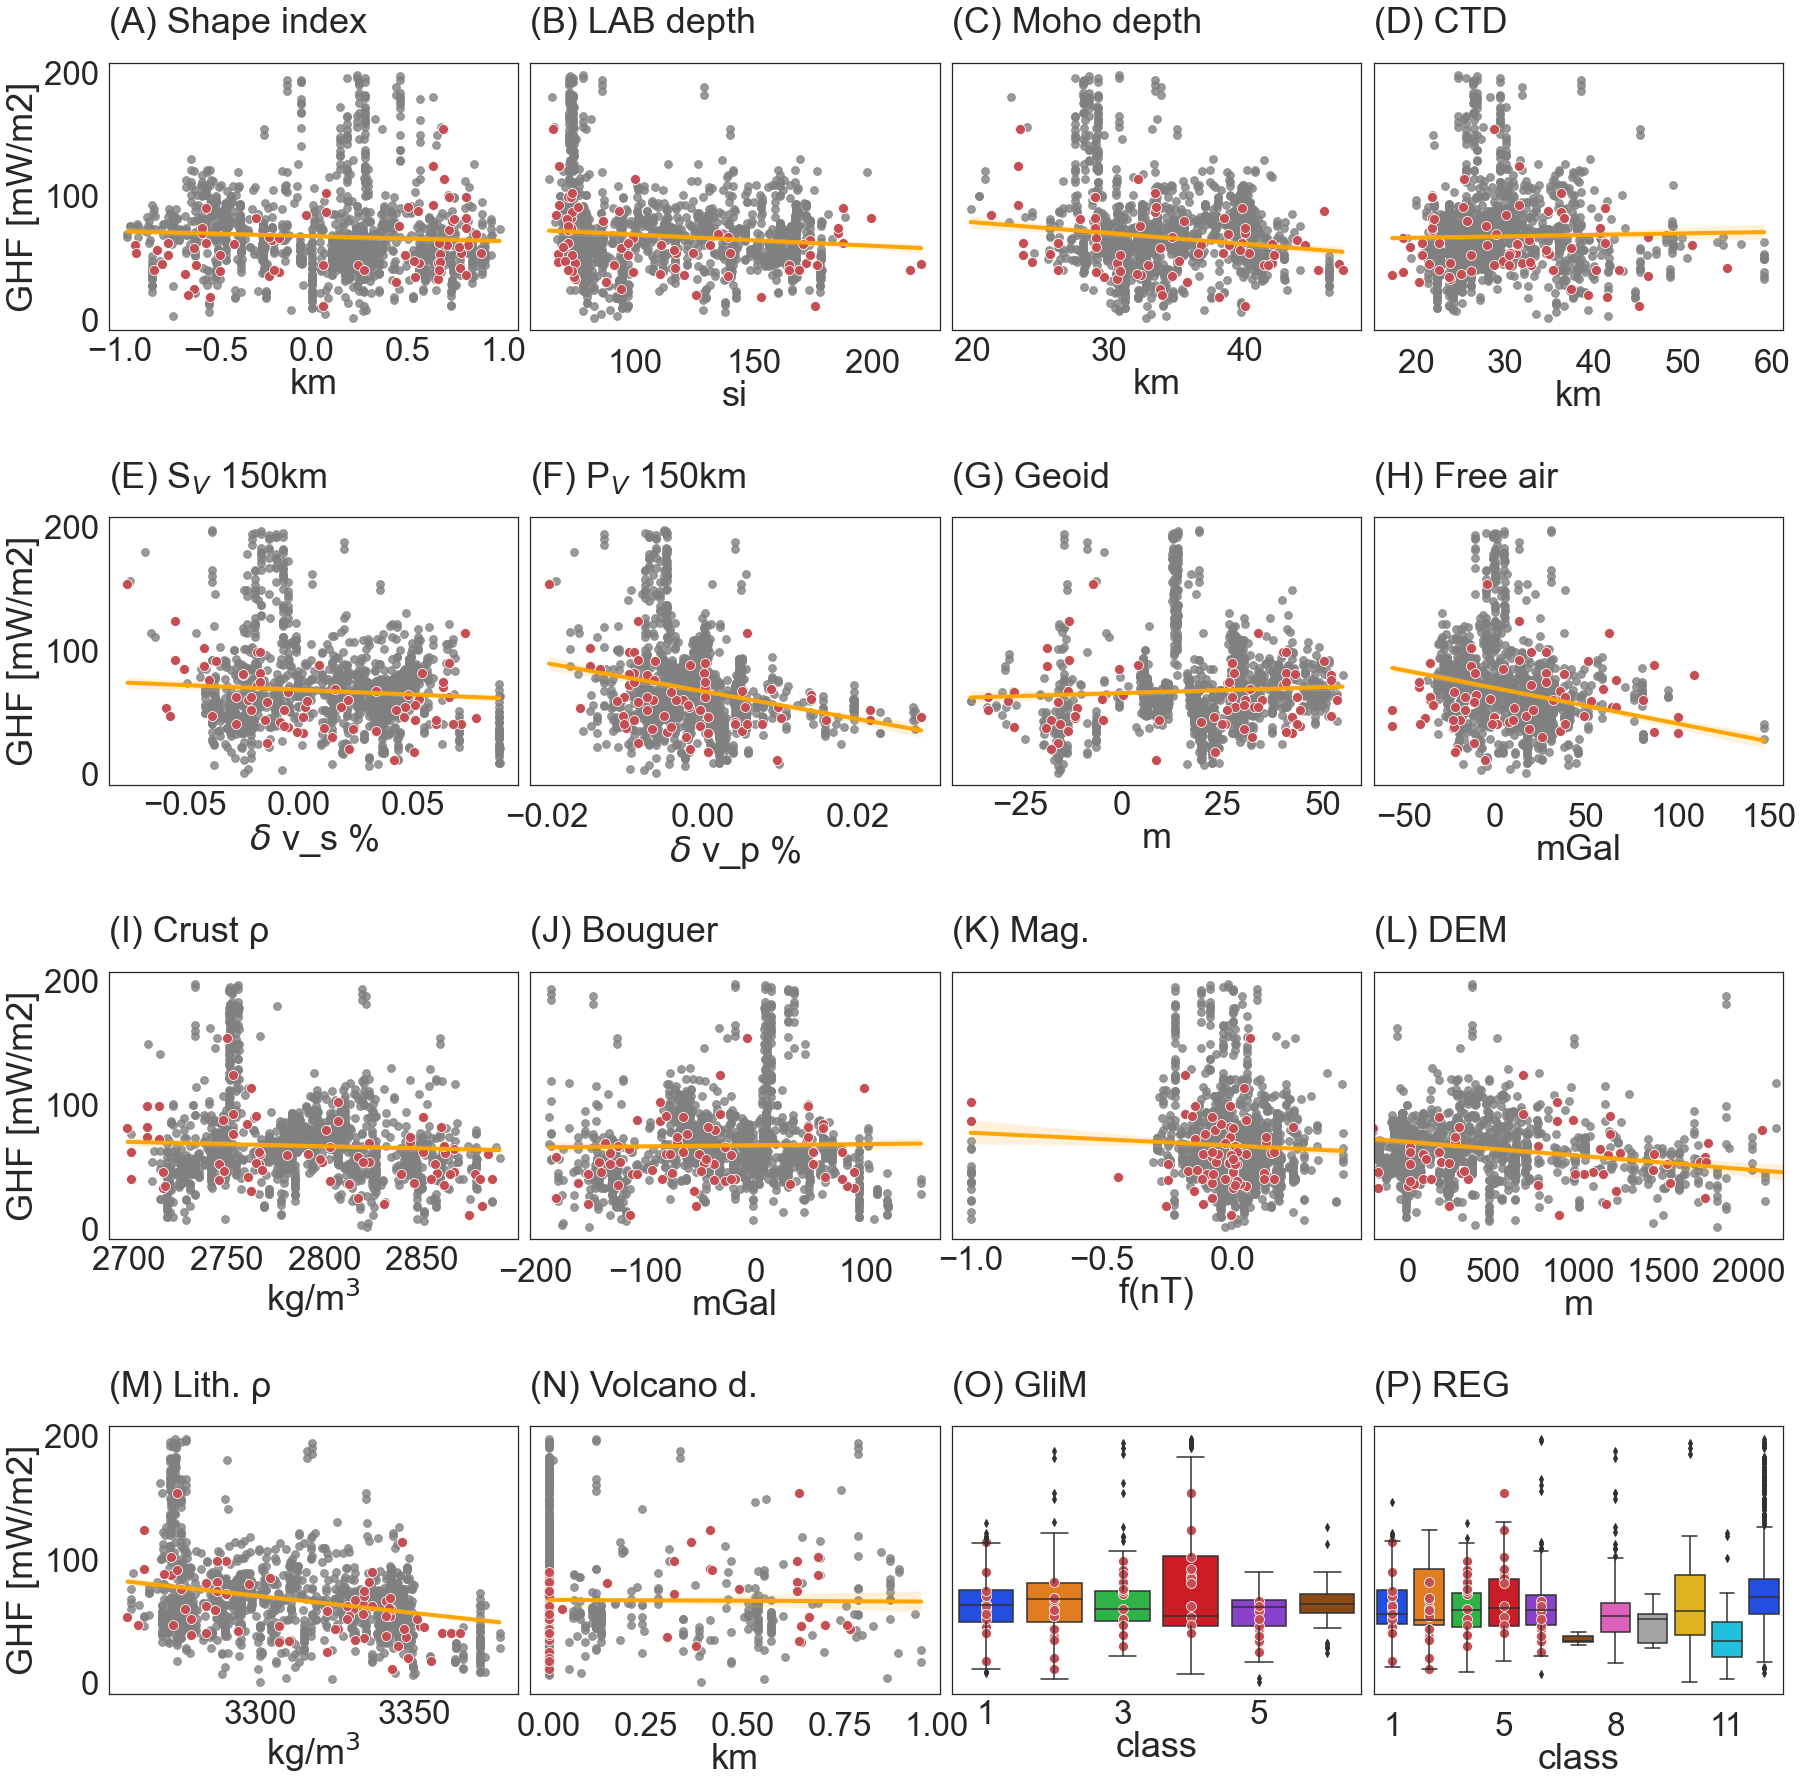

In [36]:
fig, ax = plt.subplots(4,4,figsize=(30,30),sharey=True, gridspec_kw = {'wspace':0.03},)

axs = ax.flatten()

sns.set(style="white",  font_scale = 3)

for i, feature in enumerate(obs['OBS_REF']):

    unit_i = obs['UNITS'][i]
    label_i = obs['LABELS'][i]
    range_i = obs['V_RANGE'][i]
    
    train_sod_df = pd.read_csv(training_afr_sod, sep='\t')
    removed_indexes = list(set(hf_Afr_copy_rab_n.index.tolist()) -  set(train_sod_df['index'].tolist()))

    # An lmplot
    if feature in ['GLIM','REG']:

        g0 = sns.boxplot(x=hf_Afr_copy_rab_n[feature], y=hf_Afr_copy_rab_n[target], 
                         ax=axs[i], palette='bright')
        
        sns.scatterplot(hf_Afr_copy_rab_n.loc[removed_indexes, 'REG'].cat.codes , 
                        hf_Afr_copy_rab_n[target][removed_indexes], 
                        ax= axs[i], s=100,  color='r')



        g0.set_xlabel(unit_i)
        axs[i].locator_params(axis='x', nbins=16/3)  # set divisor 


    else:
        #g0 = sns.scatterplot(x=hf_tmp[feature], y=hf_tmp[target],  ax=axs[i], size=1)
        g0 = sns.regplot(x=hf_Afr_copy_rab_n[feature], y=hf_Afr_copy_rab_n[target], ax=axs[i], 
                         line_kws={'lw': 4, 'color': 'orange'},
                         scatter_kws= {'s':60, 'color':'grey'} ,scatter=True)
        sns.scatterplot(hf_Afr_copy_rab_n.loc[removed_indexes, feature], 
                        hf_Afr_copy_rab_n[target][removed_indexes], ax= axs[i],
                        s=100,  color='r')


        g0.set_xlabel(unit_i)
        legend_properties = {'weight':'bold','size':30}
        if label_i == 'DEM' or label_i =='RHO_L':
            axs[i].set_xlim([range_i[0], range_i[1]])
         
        axs[i].locator_params(axis='x', nbins=5)  # set divisor 

    if (i%4) ==0:
        g0.set_ylabel('GHF [mW/m2]')
        g0.xaxis.labelpad = 0
    else:
        g0.set_ylabel('')
        g0.get_yaxis().set_visible(False)
        g0.xaxis.labelpad = 0

        
    if i%2 != 0:
        g0.xaxis.labelpad = 0
        g0.tick_params(axis="x",pad=12)
    else:
        g0.xaxis.labelpad = 0
        g0.tick_params(axis="x",pad=0)
        
    
    g0.set_title('(%s) %s'%(sub_figs[i],label_i), loc ='left', pad=30,  y=1)
    #axs[i].spines['right'].set_visible(False)

plt.subplots_adjust(hspace = 0.7)
plt.tight_layout()

fig.savefig(dir_p/'fig'/"fig_2.pdf", bbox_inches='tight', dpi=300 , pad_inches=0.1)
fig.savefig(dir_p/'fig'/"fig_2.jpg", bbox_inches='tight', dpi=300 , pad_inches=0.1)